In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [ ]:
import celloracle as co

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [4]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

In [5]:
adata = sc.read_h5ad("scrna.h5ad")

In [6]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

Cell number is :25551
Gene number is :2000


In [7]:
# Random downsampling into 30K cells if the anndata object include more than 30 K cells.
n_cells_downsample = 30000
if adata.shape[0] > n_cells_downsample:
    # Let's dowmsample into 30K cells
    sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123)

In [9]:
base_GRN = co.data.load_human_promoter_base_GRN()

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
Data not found in the local folder. Loading data from github. Data will be saved at /home/kwf2110/celloracle_data/promoter_base_GRN


  0%|          | 0.00/5.26M [00:00<?, ?B/s]

In [10]:
base_GRN.head()

peak_id gene_short_name  9430076C15RIK  AC002126.6  \
0  chr10_100027907_100029007           LOXL4            0.0         0.0   
1  chr10_100154964_100156064         MIR1287            0.0         0.0   
2  chr10_100174878_100175978         PYROXD2            0.0         0.0   
3  chr10_100191017_100192117         MIR4685            0.0         1.0   
4  chr10_100205078_100206178    LOC101927278            0.0         0.0   

   AC012531.1  AC226150.2  AFP  AHR  AHRR  AIRE  ...  ZNF784  ZNF8  ZNF816  \
0         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
2         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   ZNF85  ZSCAN10  ZSCAN16  ZSCAN22  ZSCAN26  ZSCAN31  ZSCAN4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1096 columns]

In [11]:
# Instantiate Oracle object
oracle = co.Oracle()

In [12]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['cell_type', 'n_counts_all', 'n_counts', 'louvain']
Dimensional reduction:  ['X_diffmap', 'X_draw_graph_fr', 'X_pca']


In [14]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["raw_count"].copy()

# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="louvain",
                                   embedding_name="X_draw_graph_fr")

In [15]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

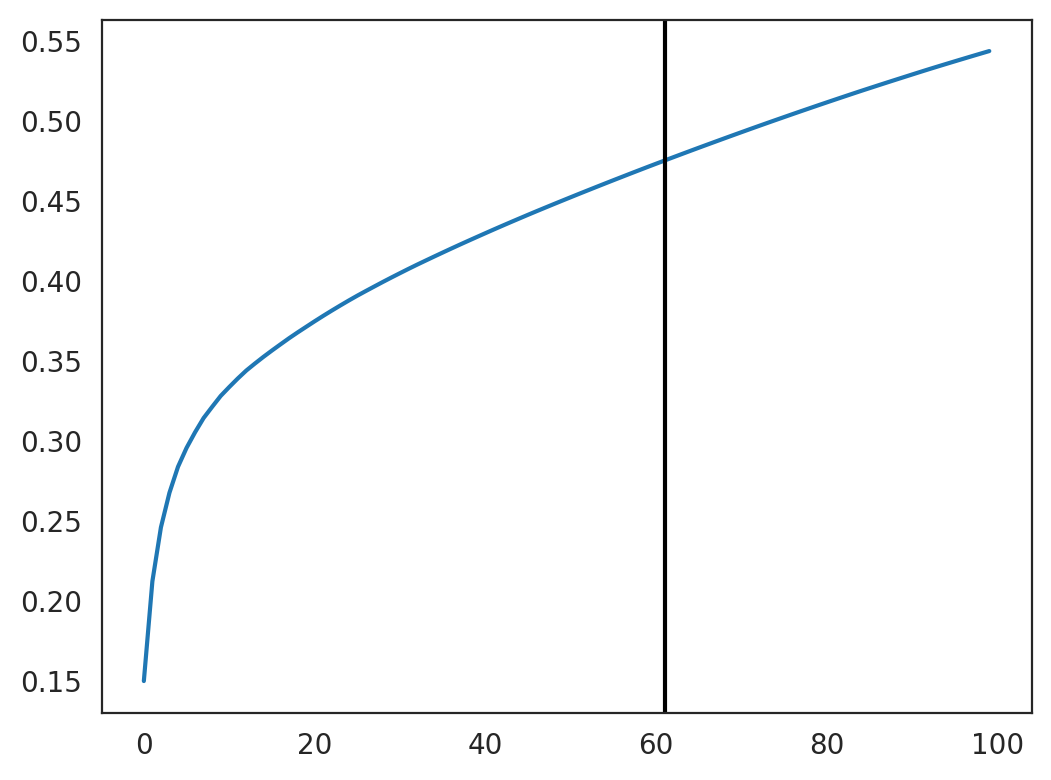

61


In [16]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [17]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :25551


In [18]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :638


In [19]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [20]:
# Save oracle object.
oracle.to_hdf5("data.celloracle.oracle")

In [22]:
# Load file.
oracle = co.load_hdf5("data.celloracle.oracle")

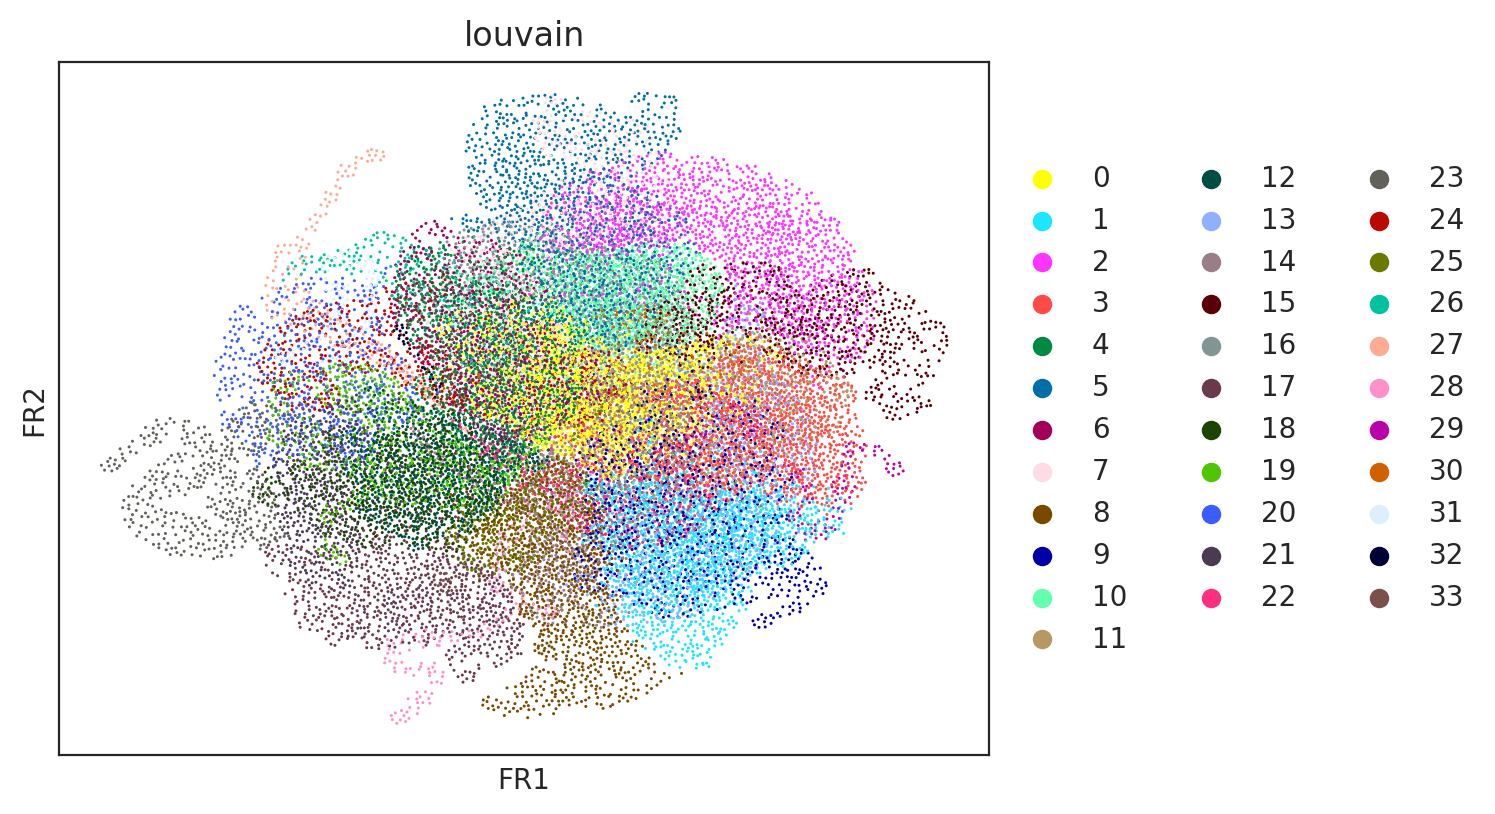

In [24]:
# Check clustering data
sc.pl.draw_graph(oracle.adata, color="louvain")

In [26]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="louvain", alpha=10,
                         verbose_level=10)

  0%|          | 0/34 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/1524 [00:00<?, ?it/s]

Inferring GRN for 1...


  0%|          | 0/1524 [00:00<?, ?it/s]

Inferring GRN for 10...


  0%|          | 0/1524 [00:00<?, ?it/s]

Inferring GRN for 11...


  0%|          | 0/1524 [00:00<?, ?it/s]

Inferring GRN for 12...


  0%|          | 0/1524 [00:00<?, ?it/s]

Inferring GRN for 13...


  0%|          | 0/1524 [00:00<?, ?it/s]

Inferring GRN for 14...


  0%|          | 0/1524 [00:00<?, ?it/s]

Inferring GRN for 16...


  0%|          | 0/1524 [00:00<?, ?it/s]

Inferring GRN for 17...


  0%|          | 0/1524 [00:00<?, ?it/s]

Inferring GRN for 18...


  0%|          | 0/1524 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [27]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

In [29]:
links.links_dict.keys()

dict_keys(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '4', '5', '6', '7', '8', '9'])

In [30]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [31]:
plt.rcParams["figure.figsize"] = [9, 4.5]

0


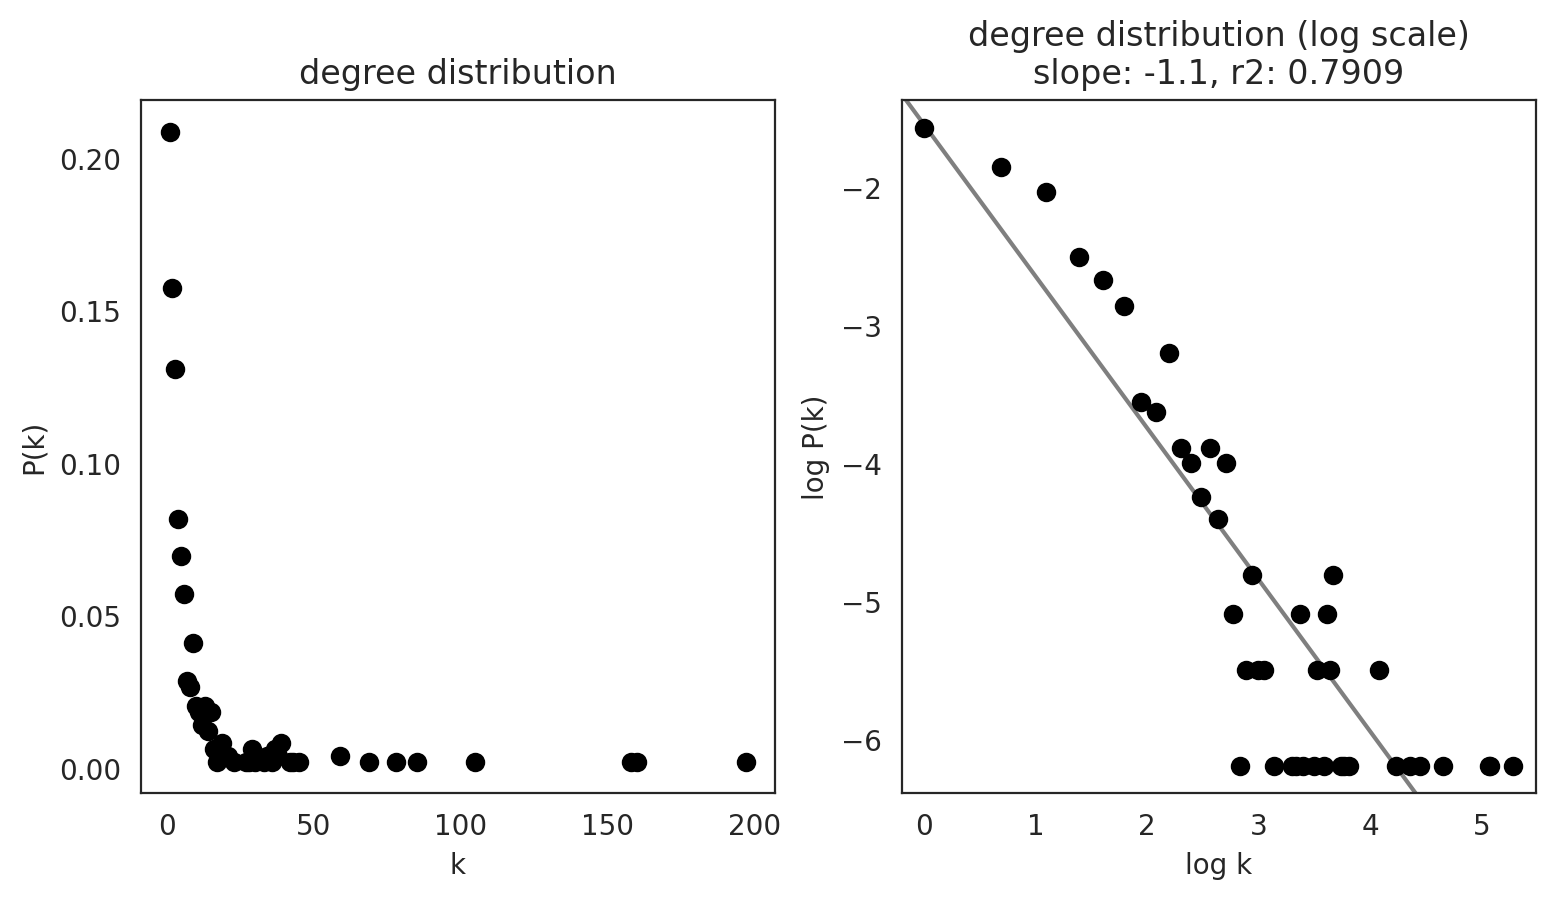

1


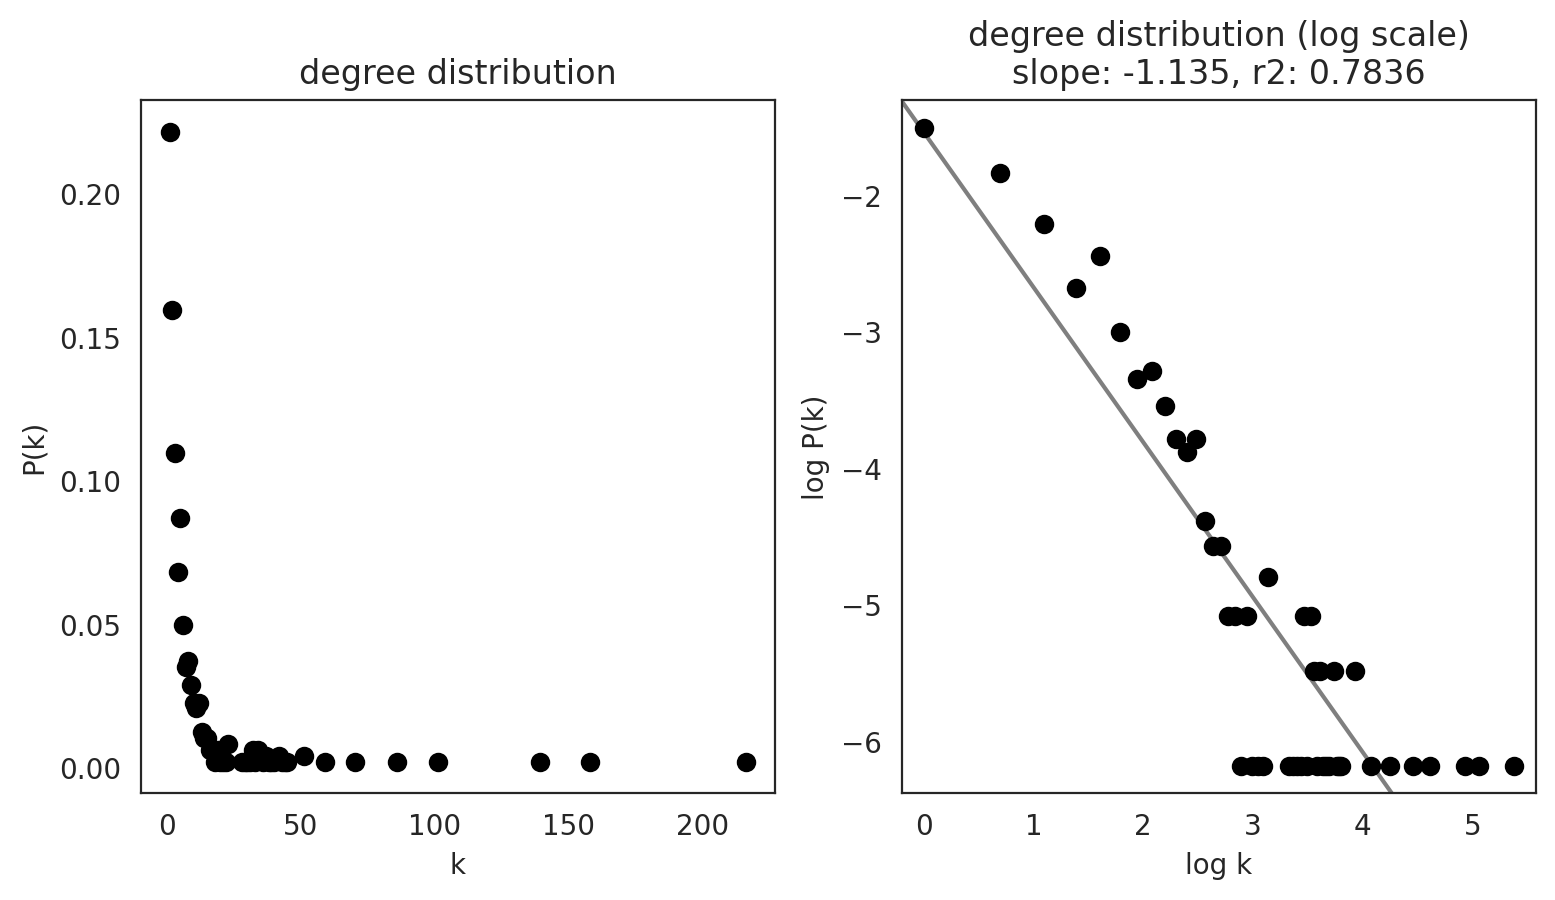

10


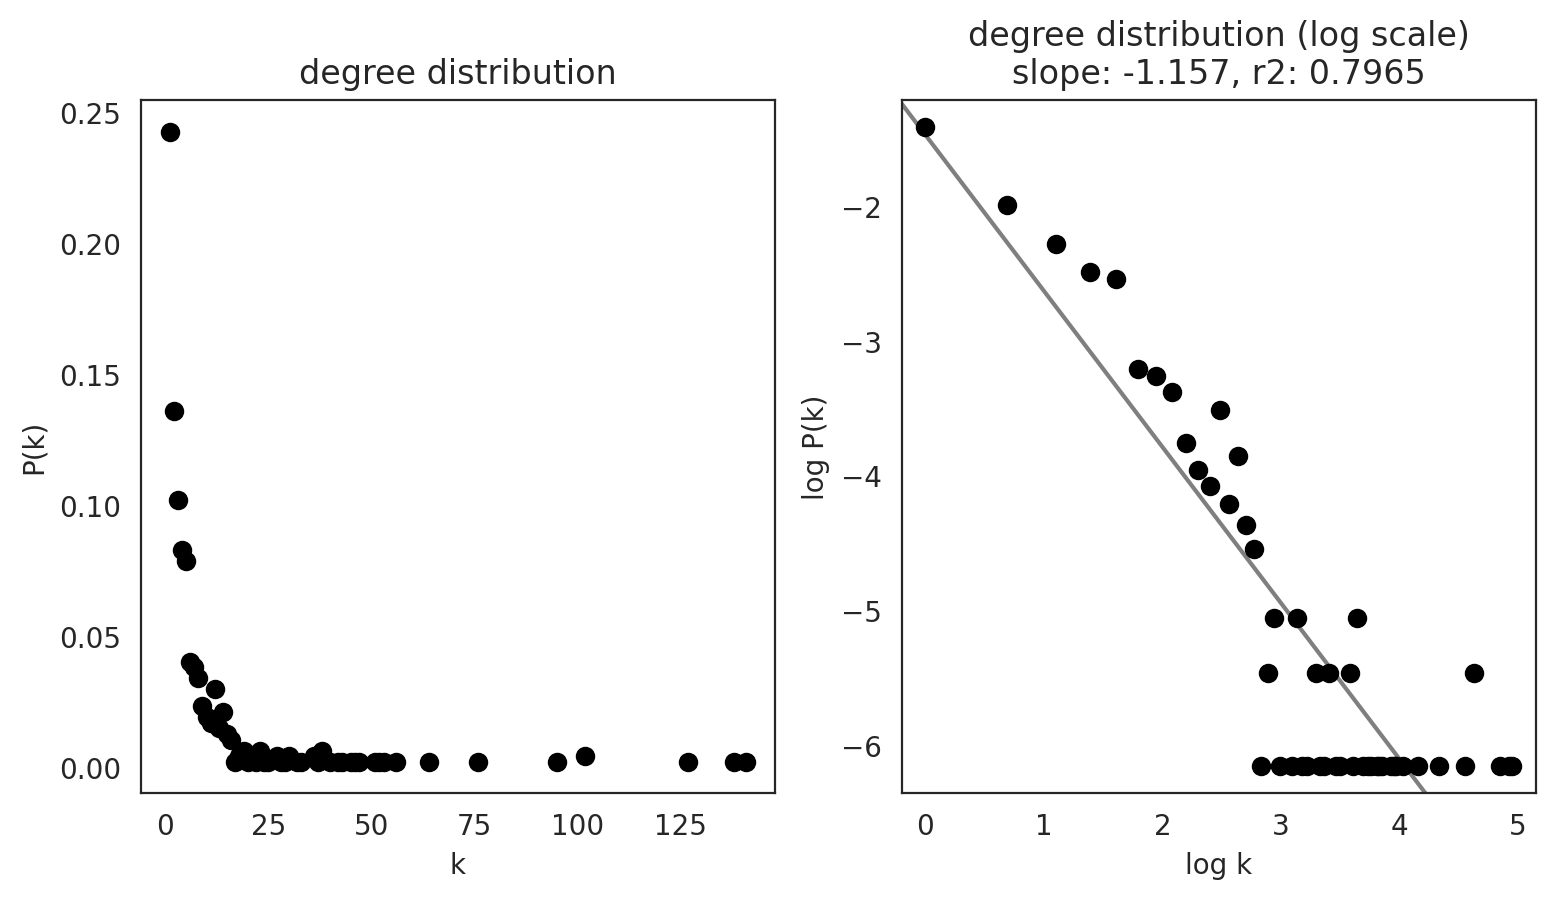

11


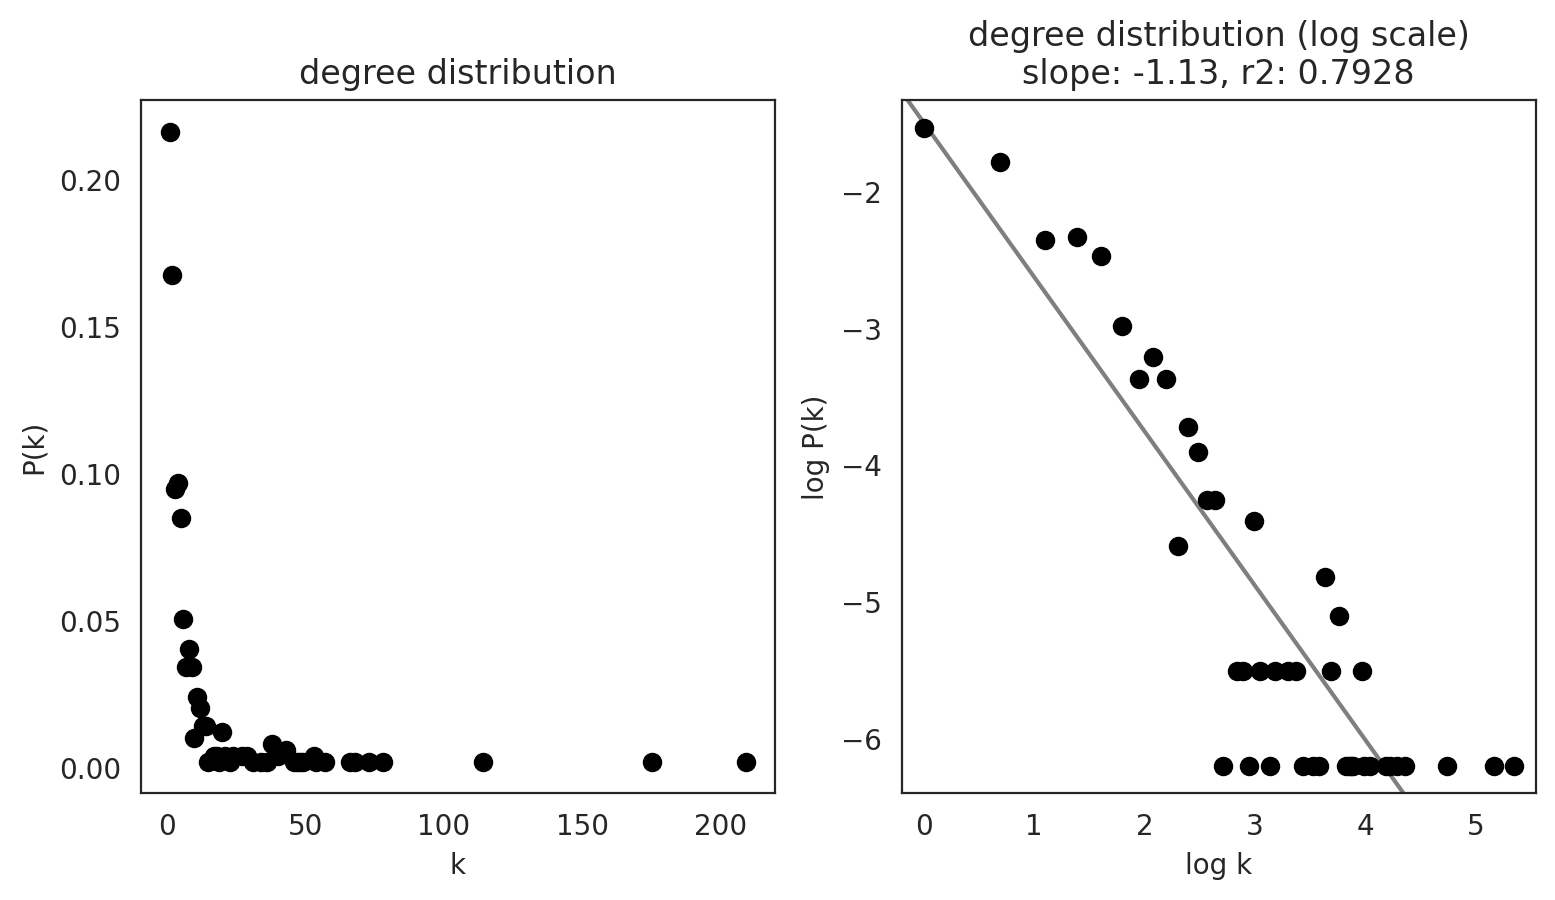

12


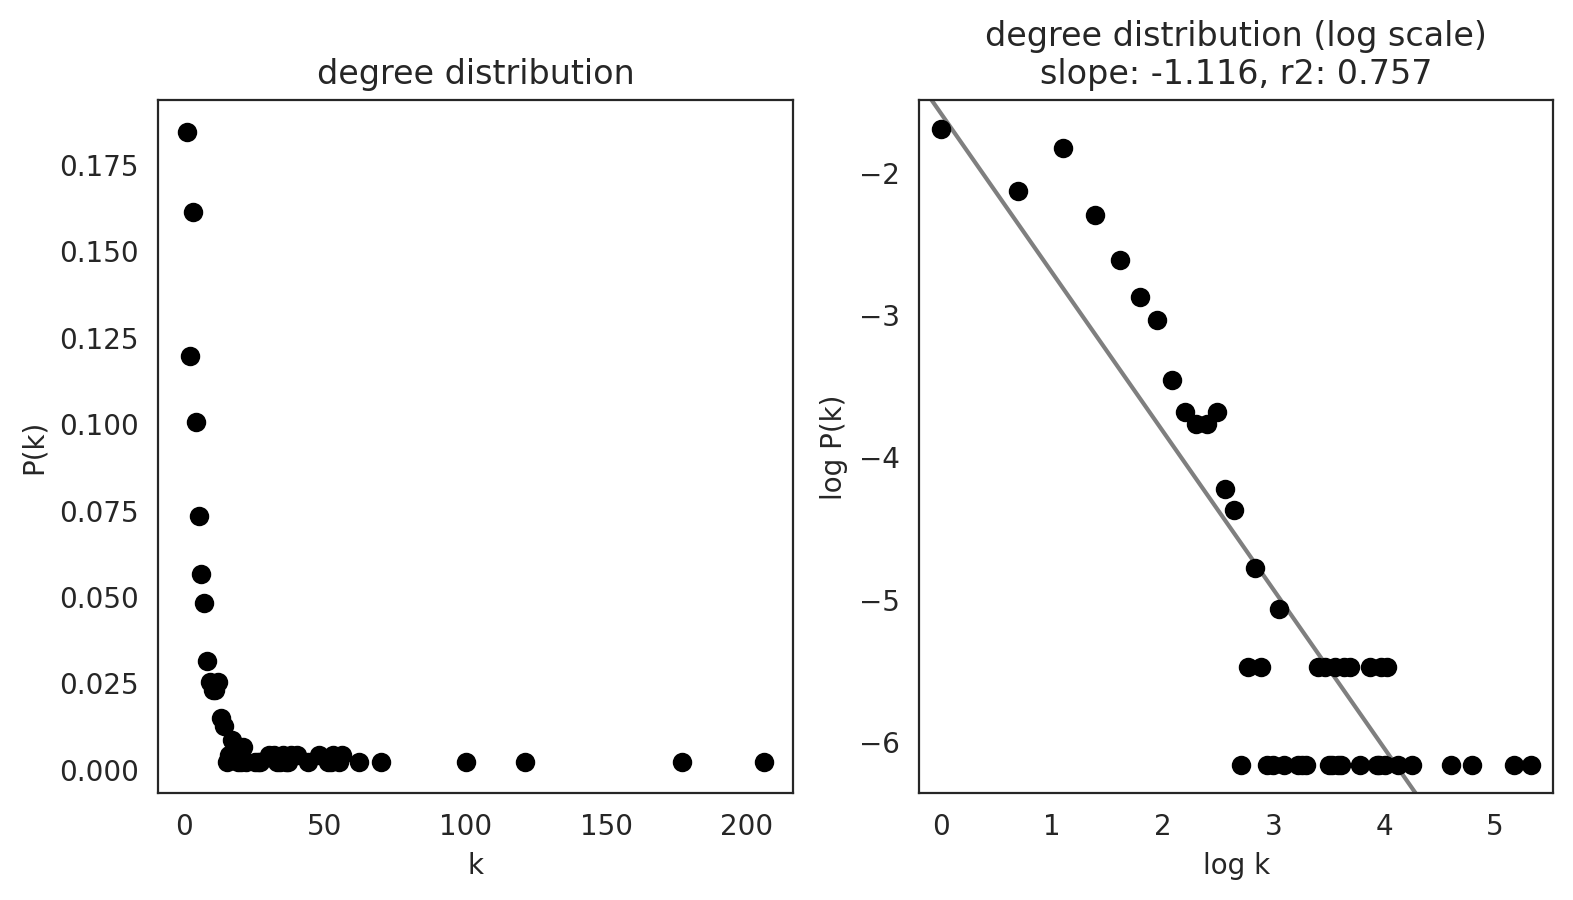

13


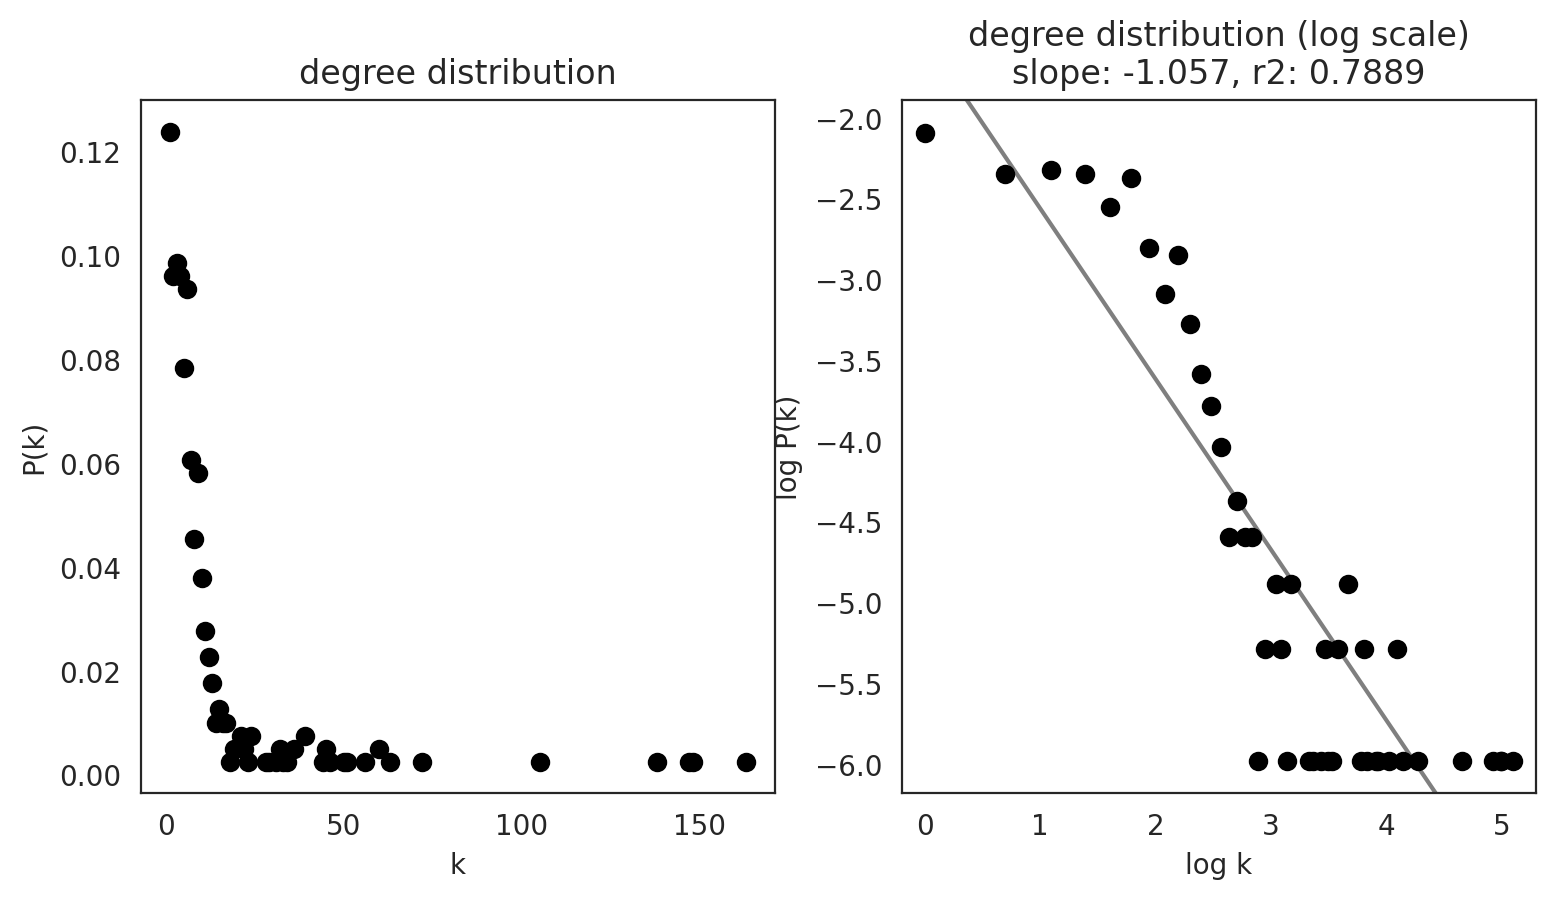

14


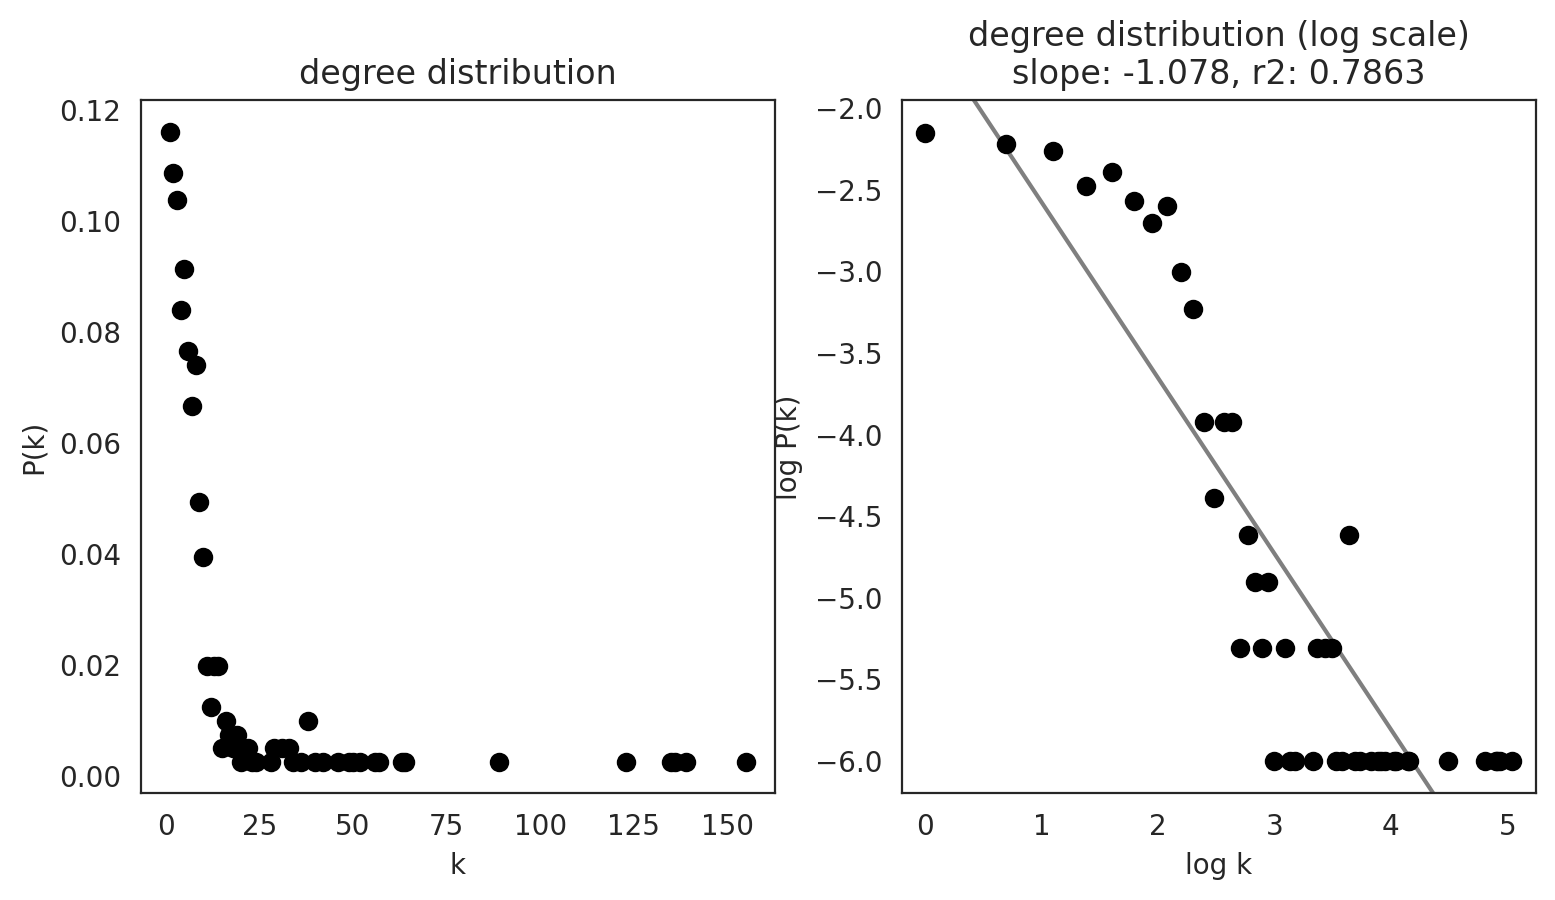

15


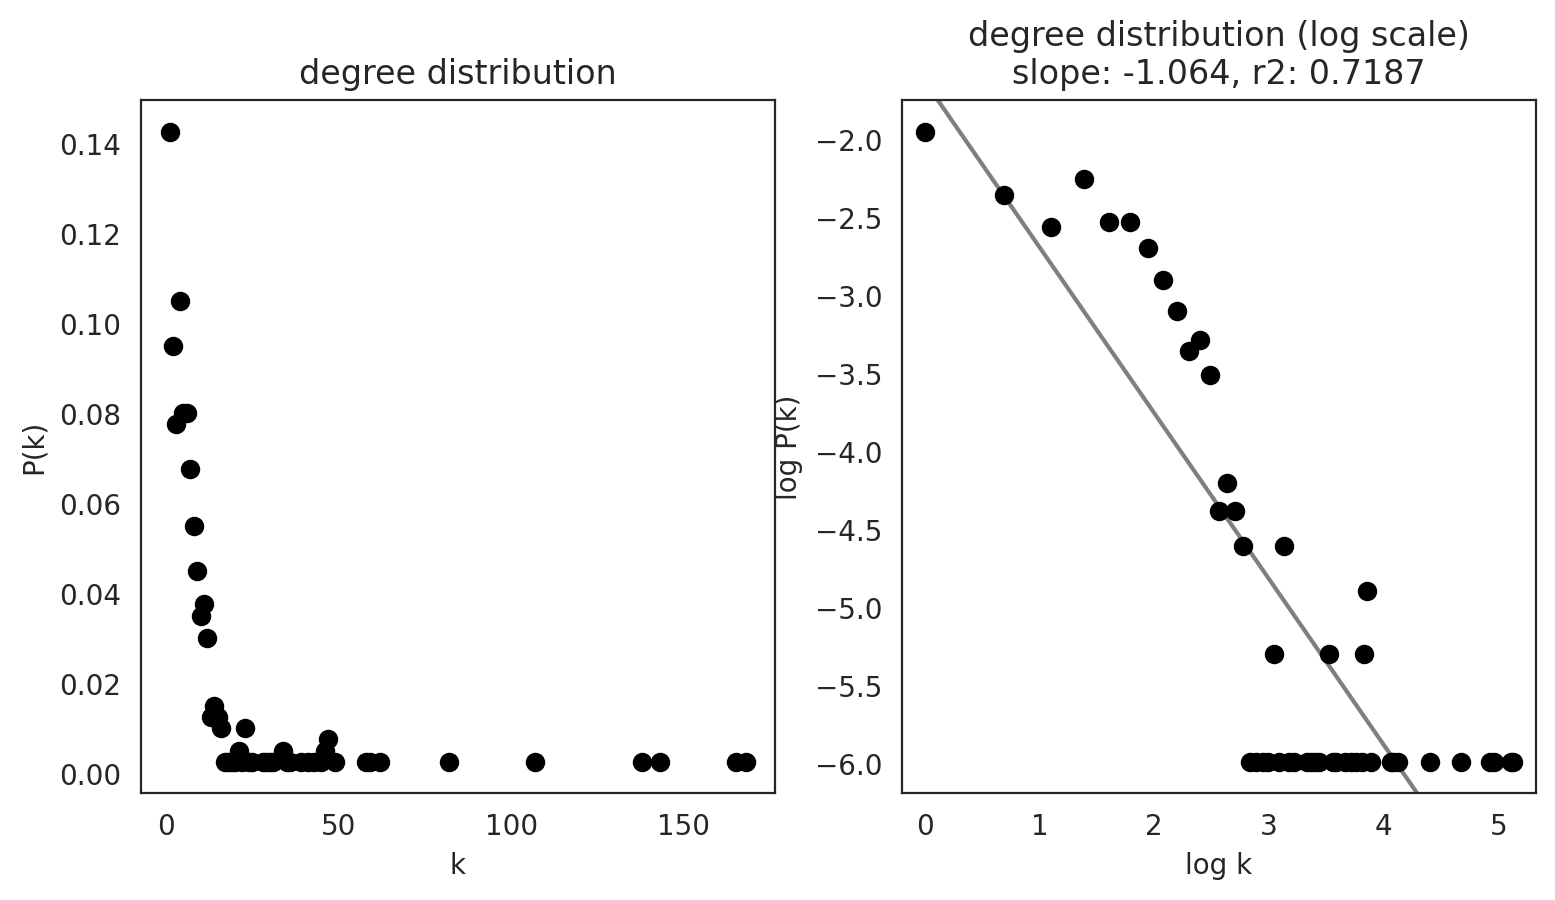

16


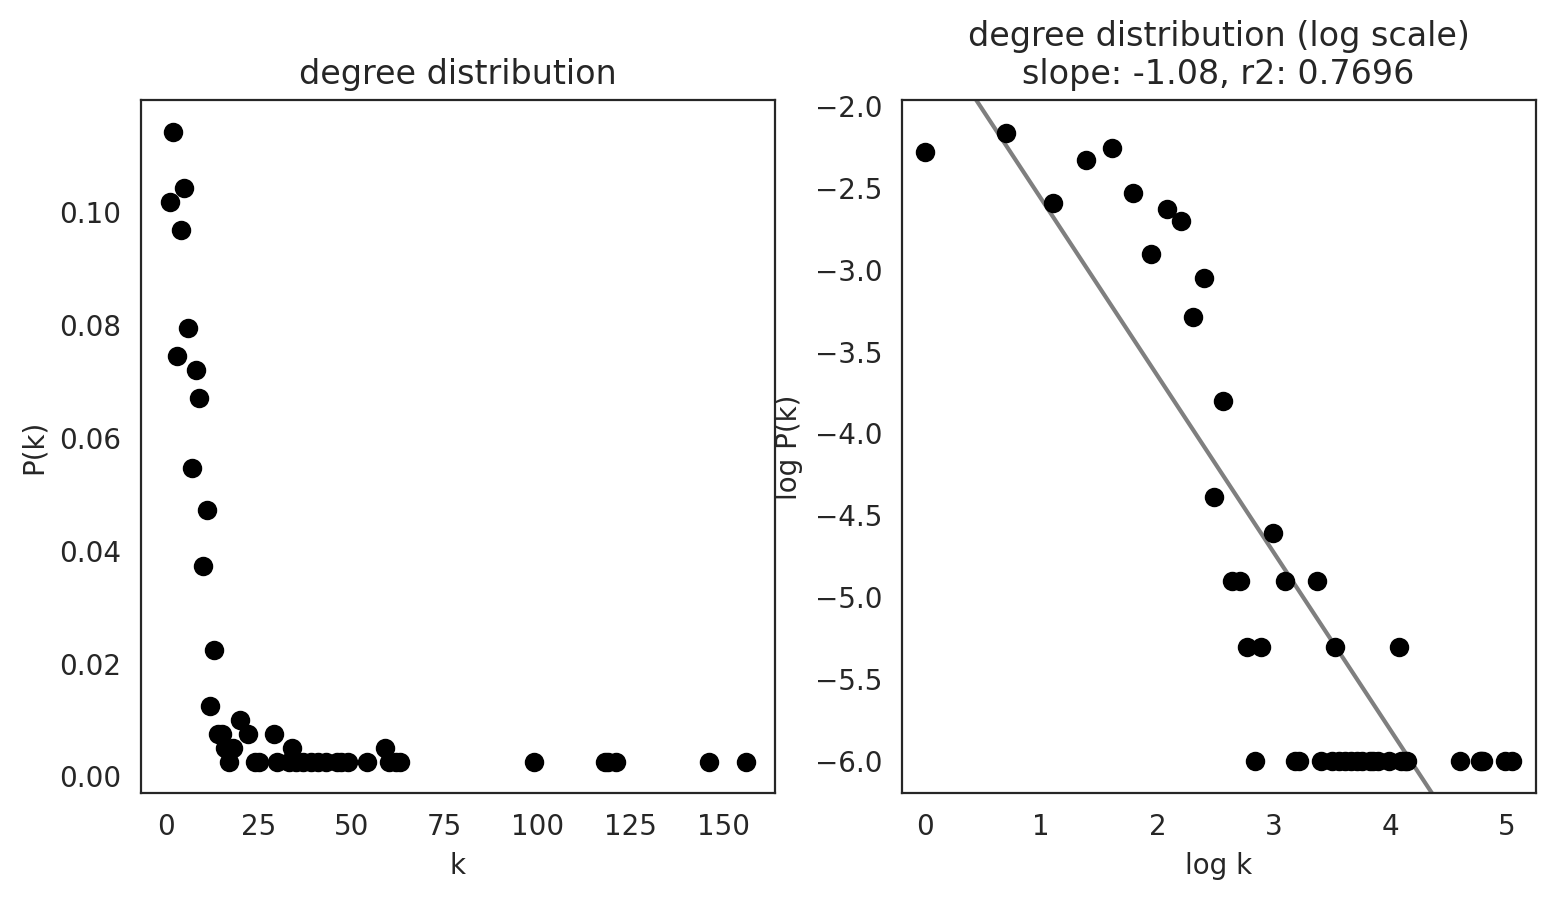

17


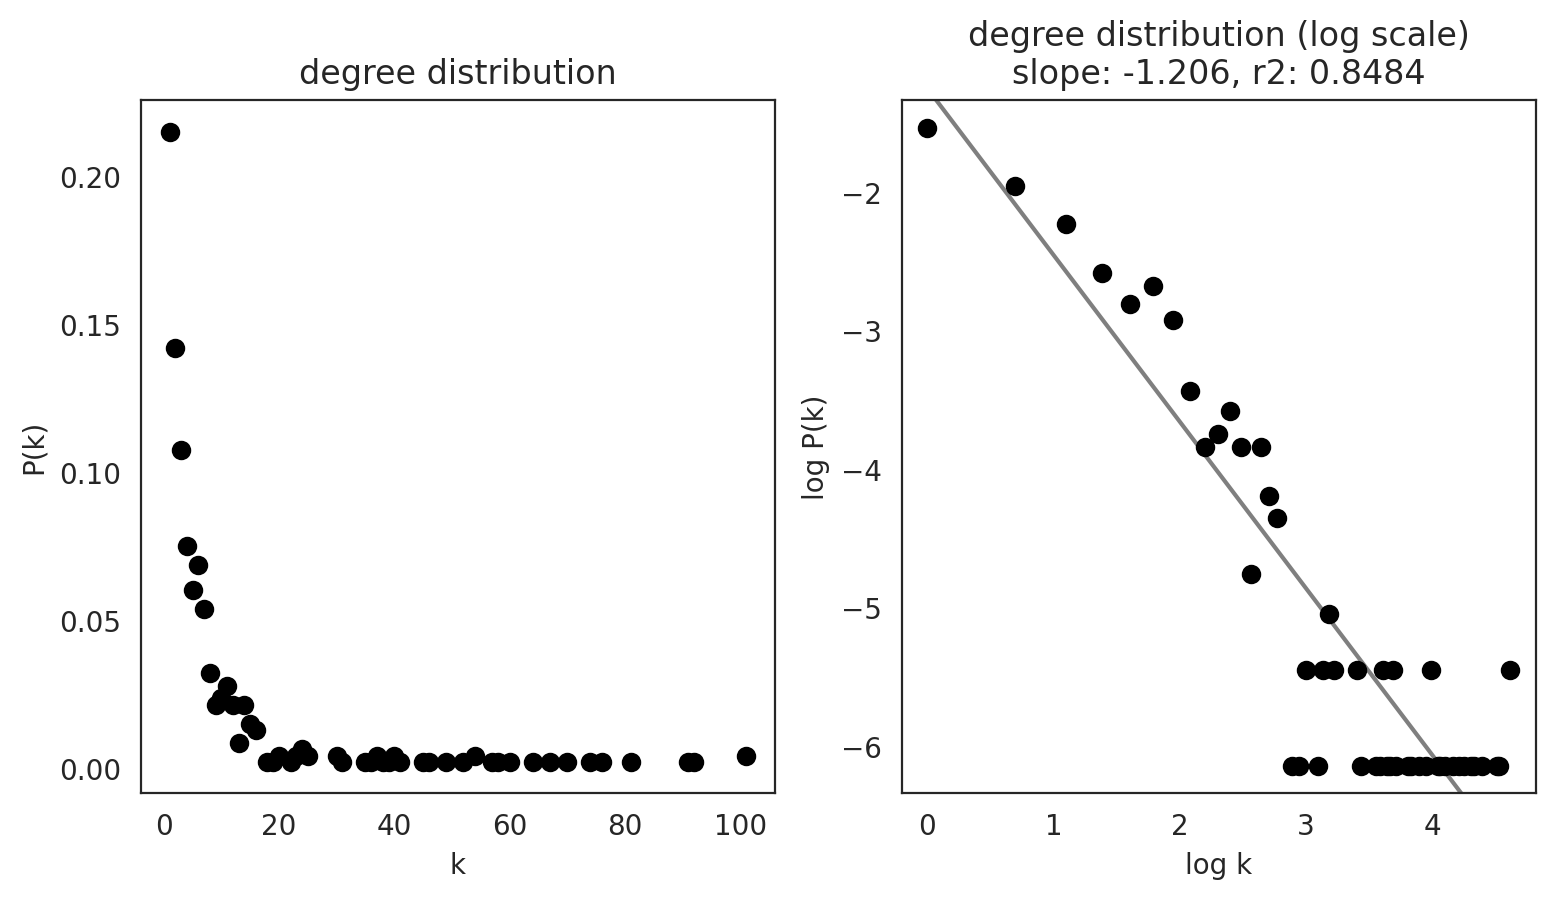

18


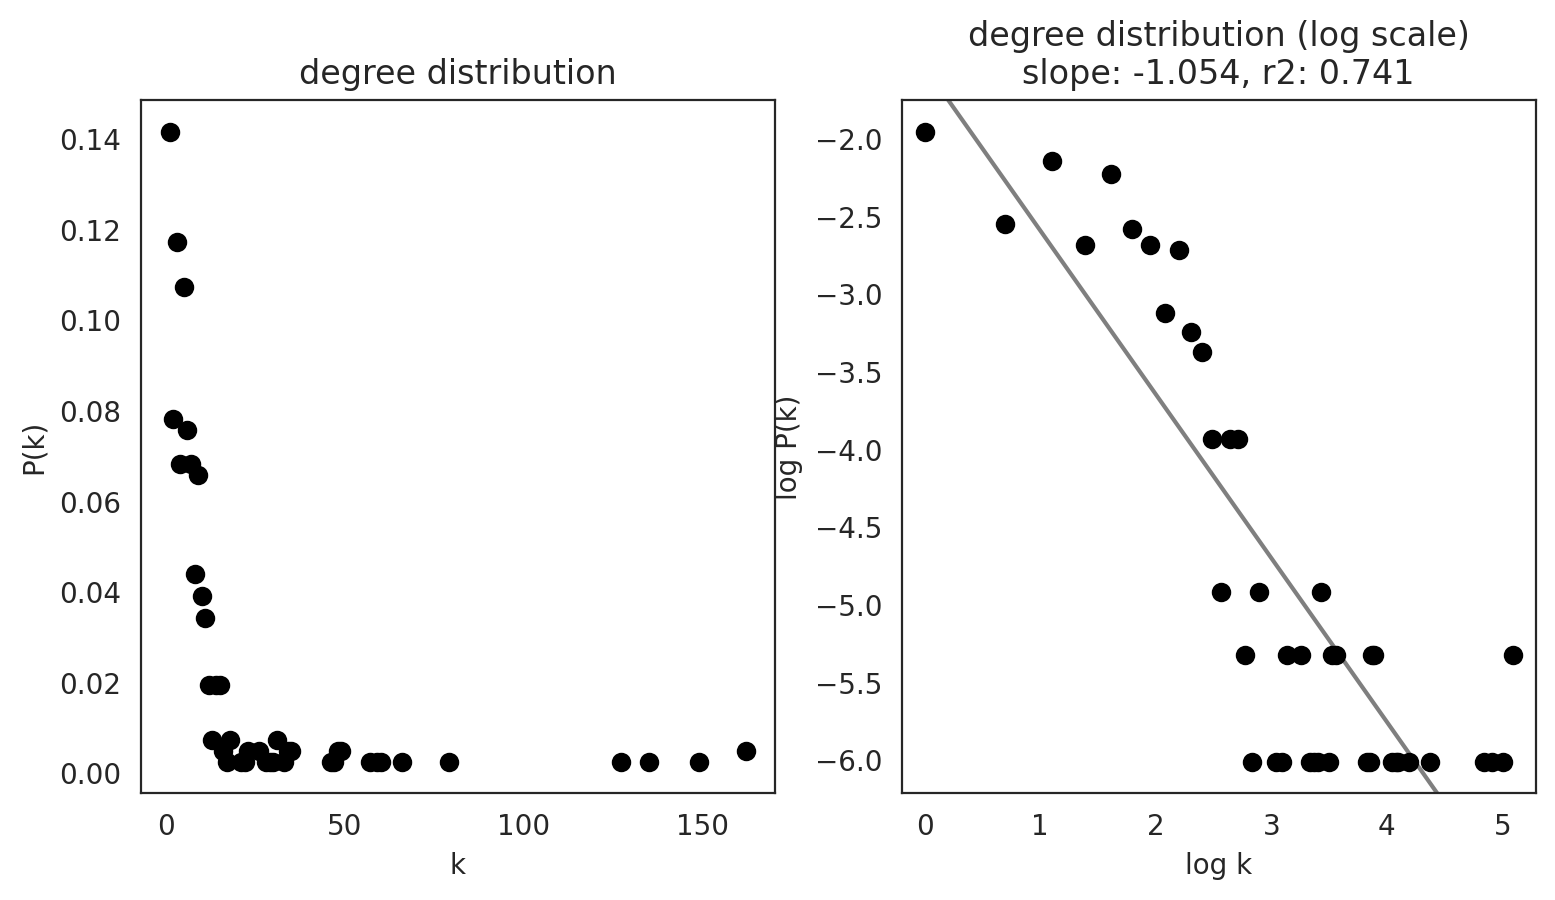

19


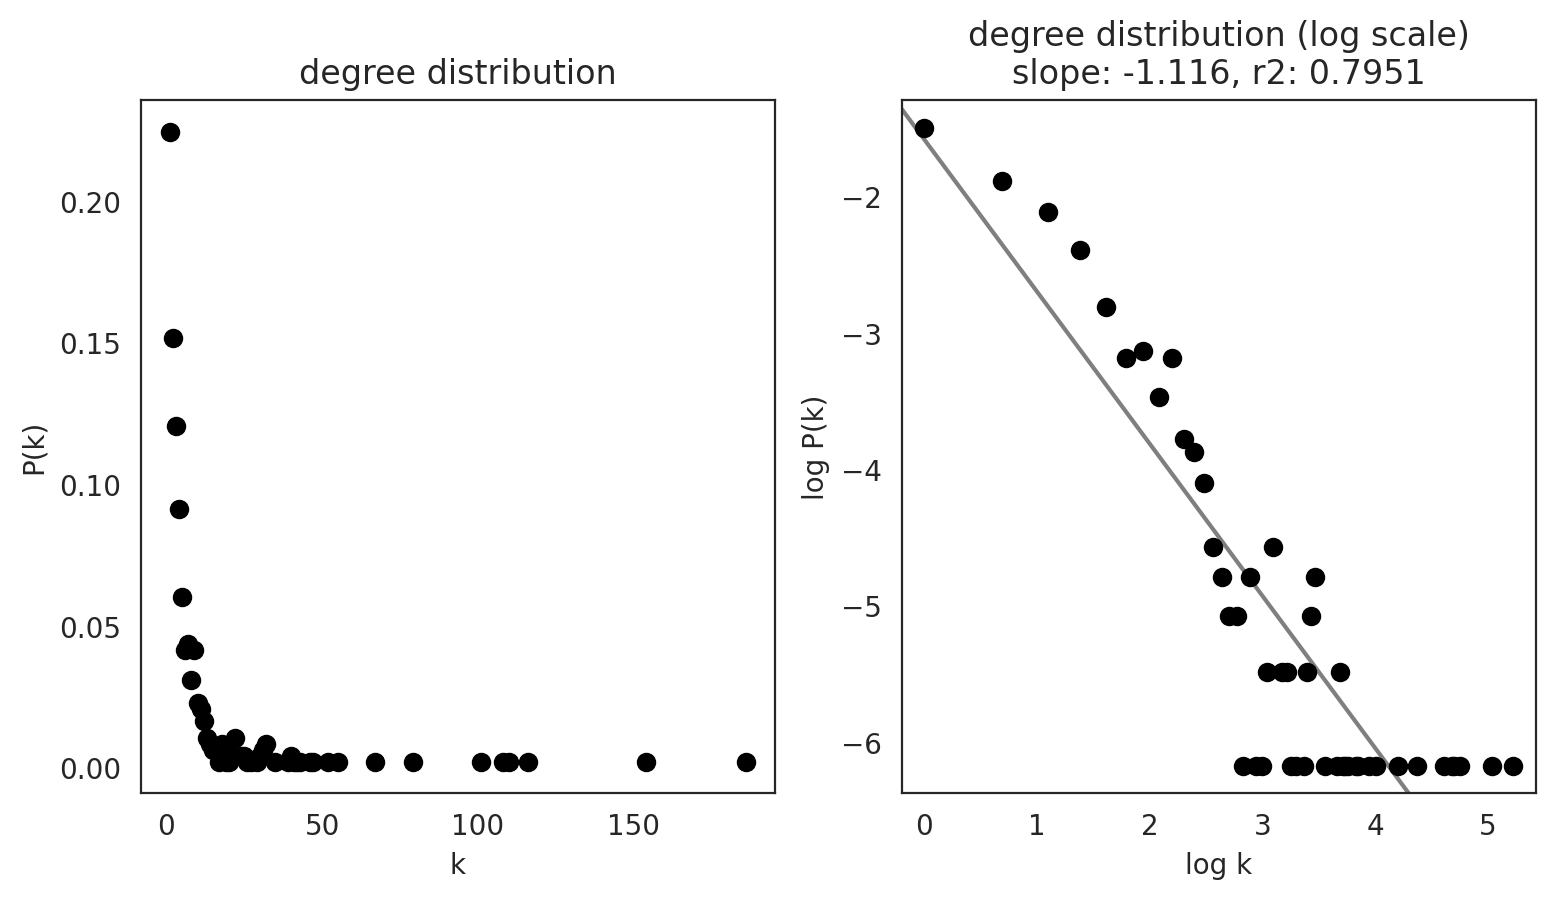

2


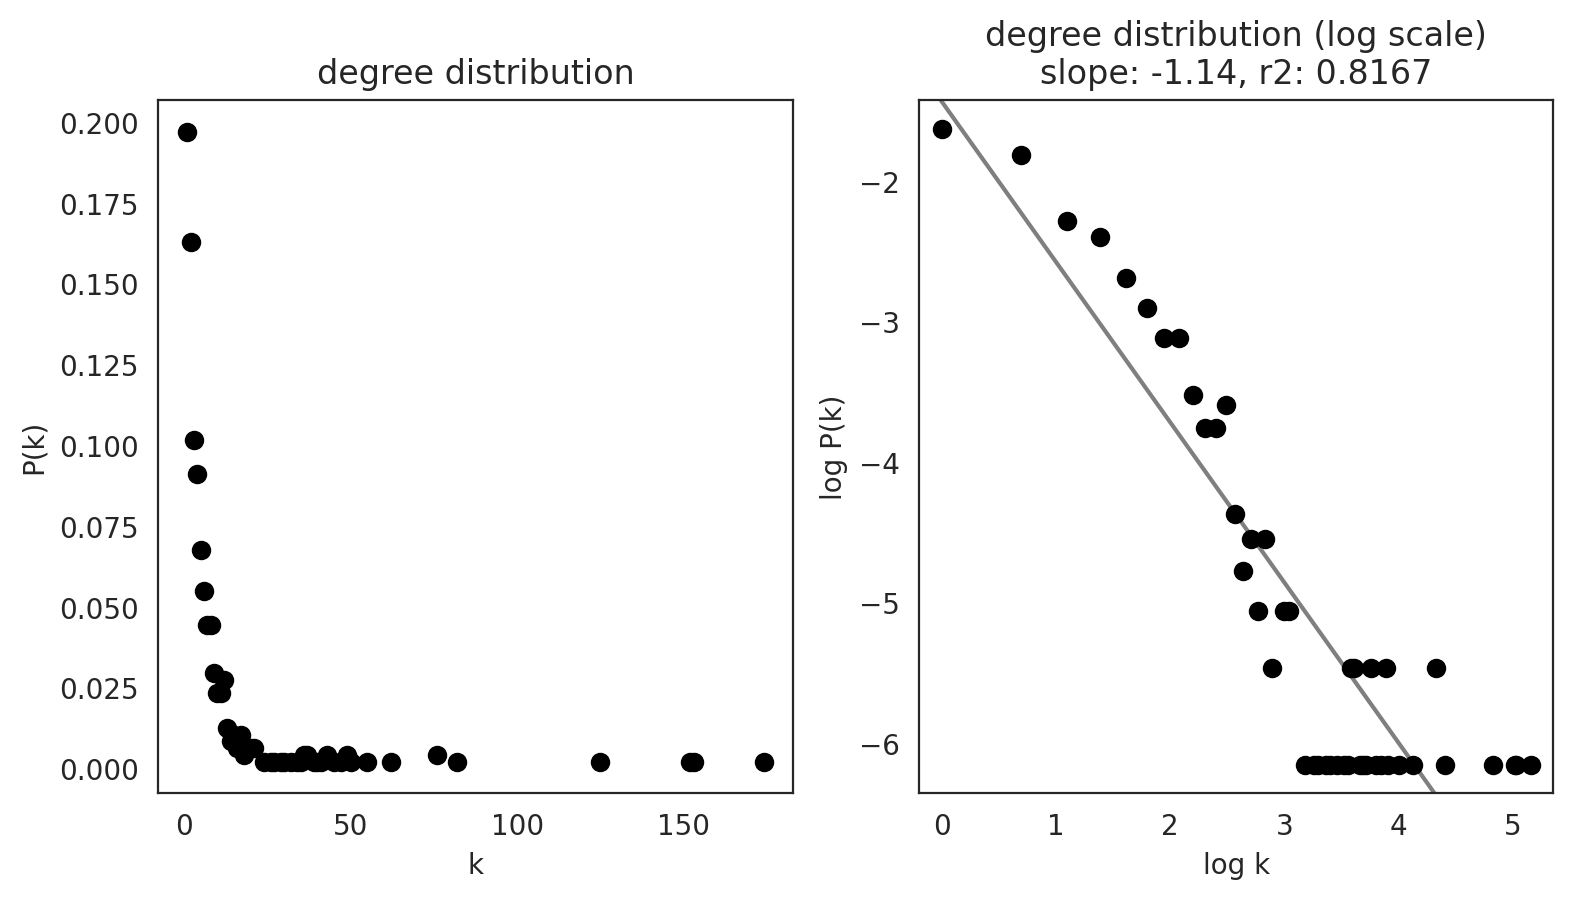

20


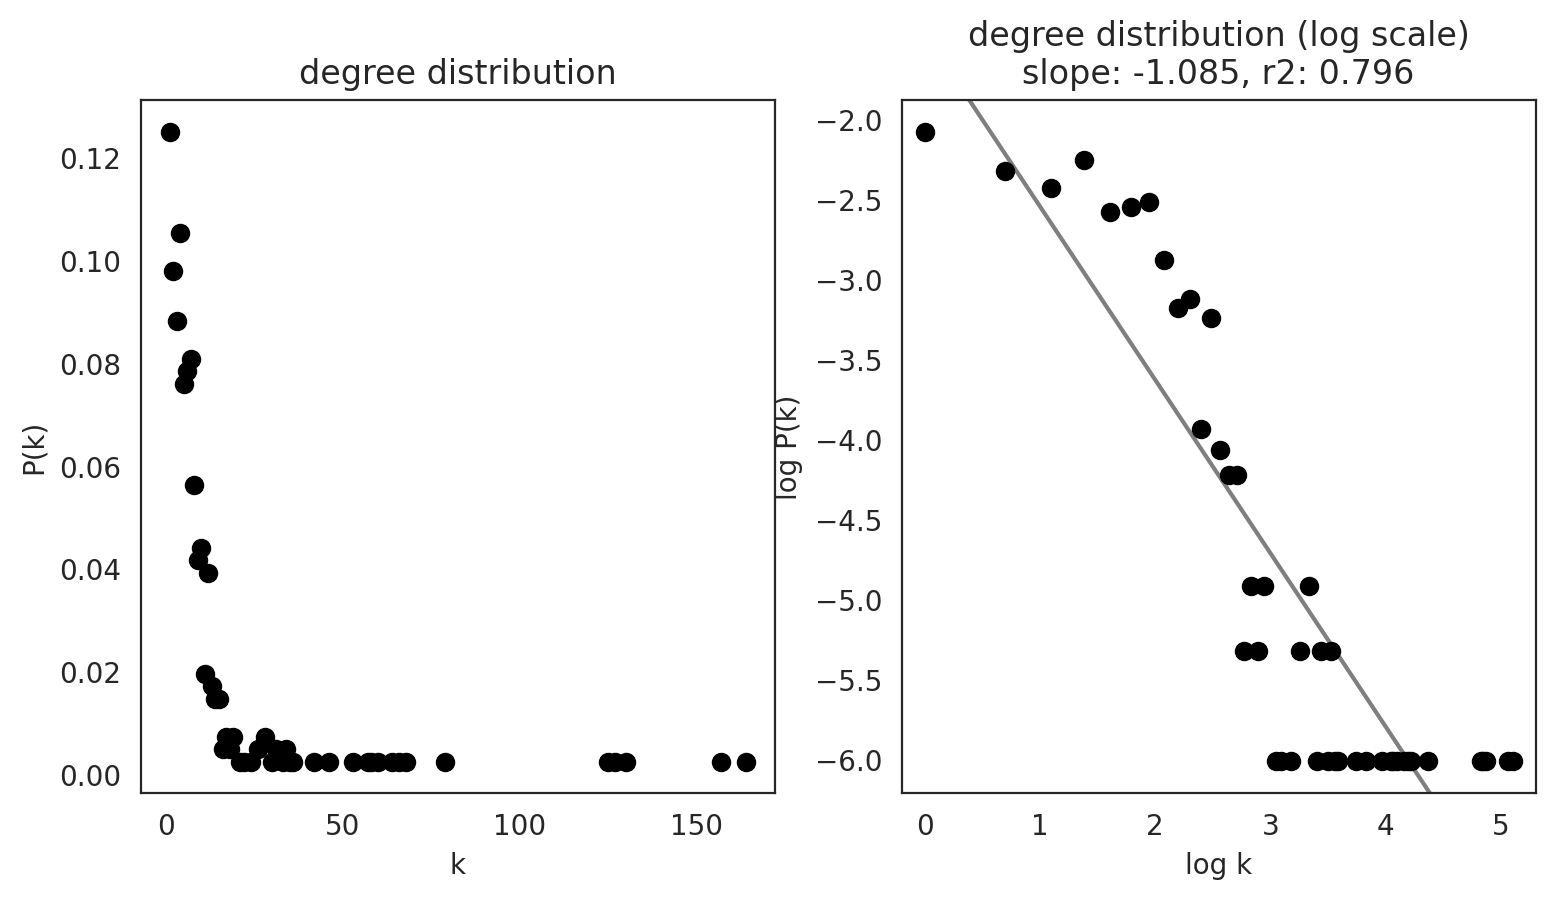

21


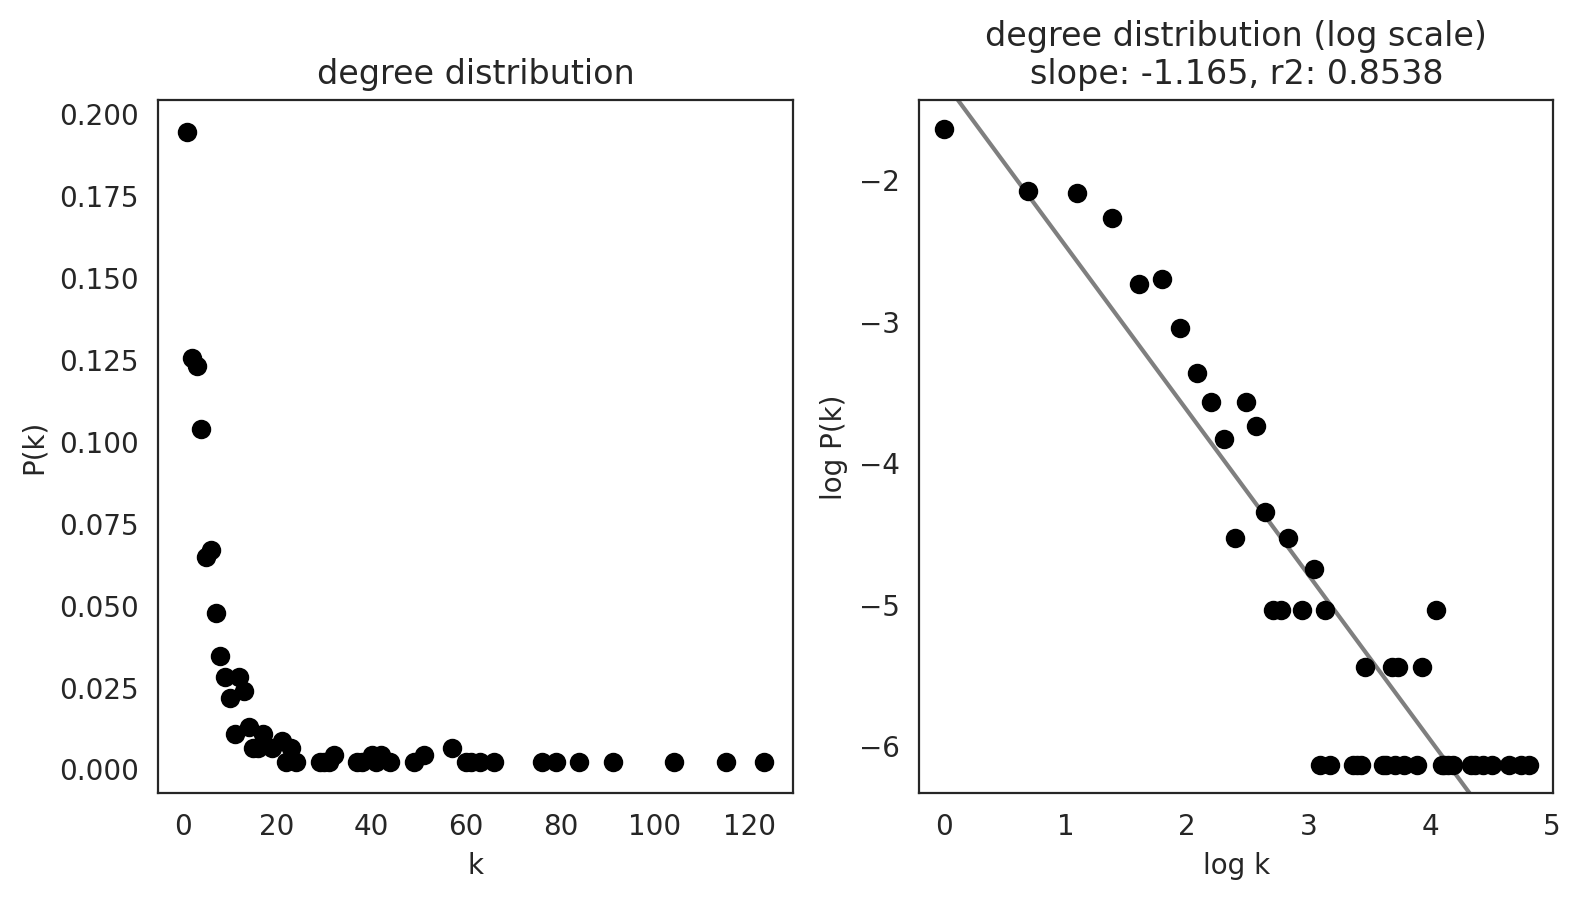

22


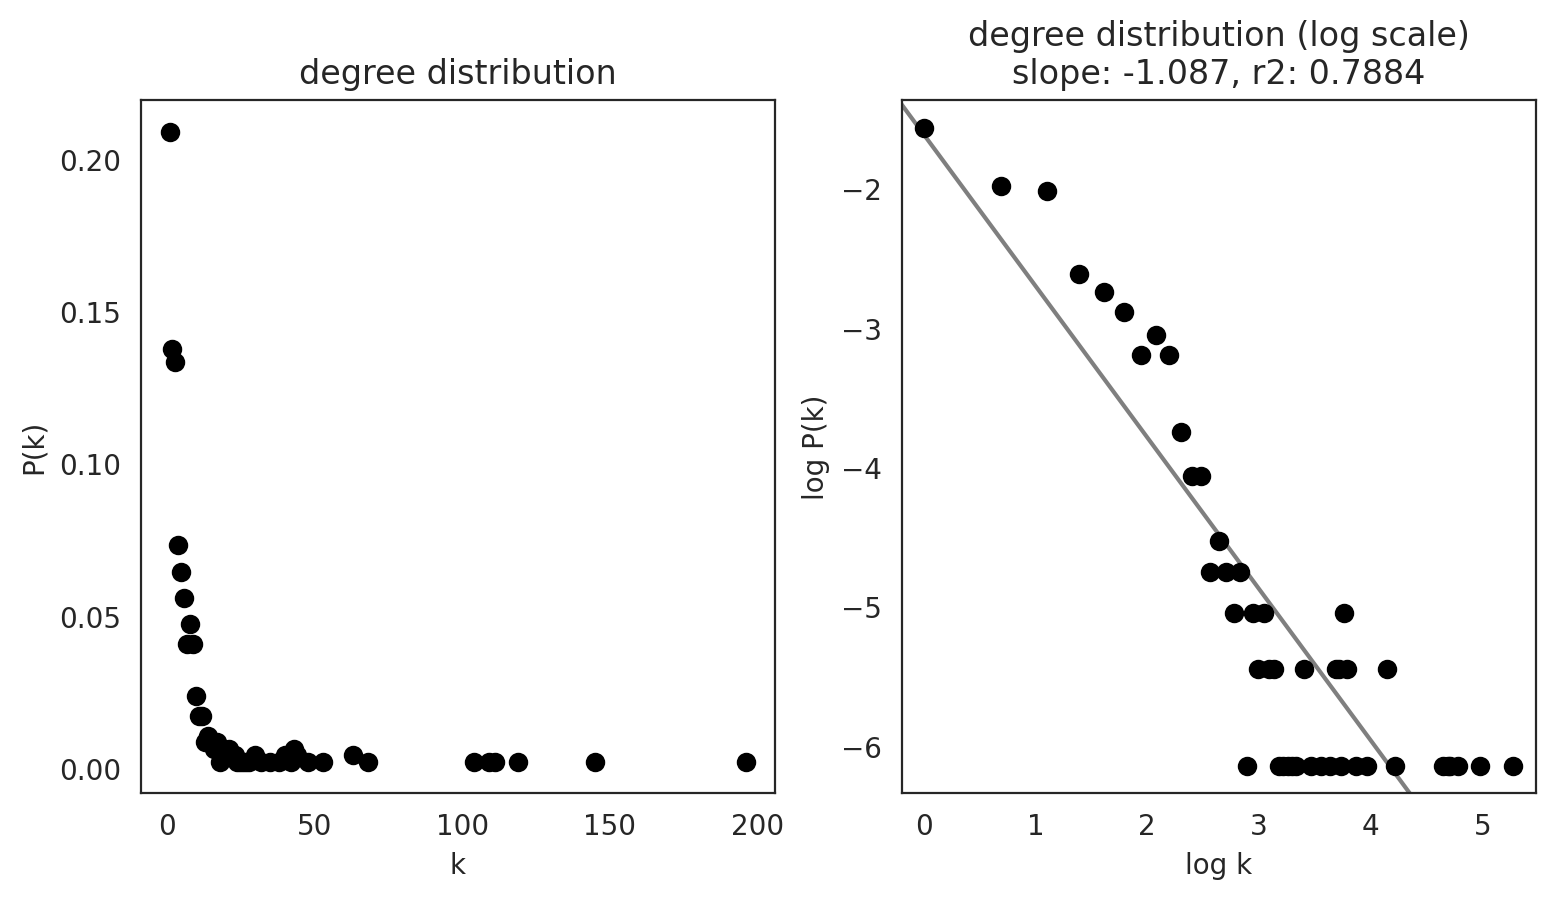

23


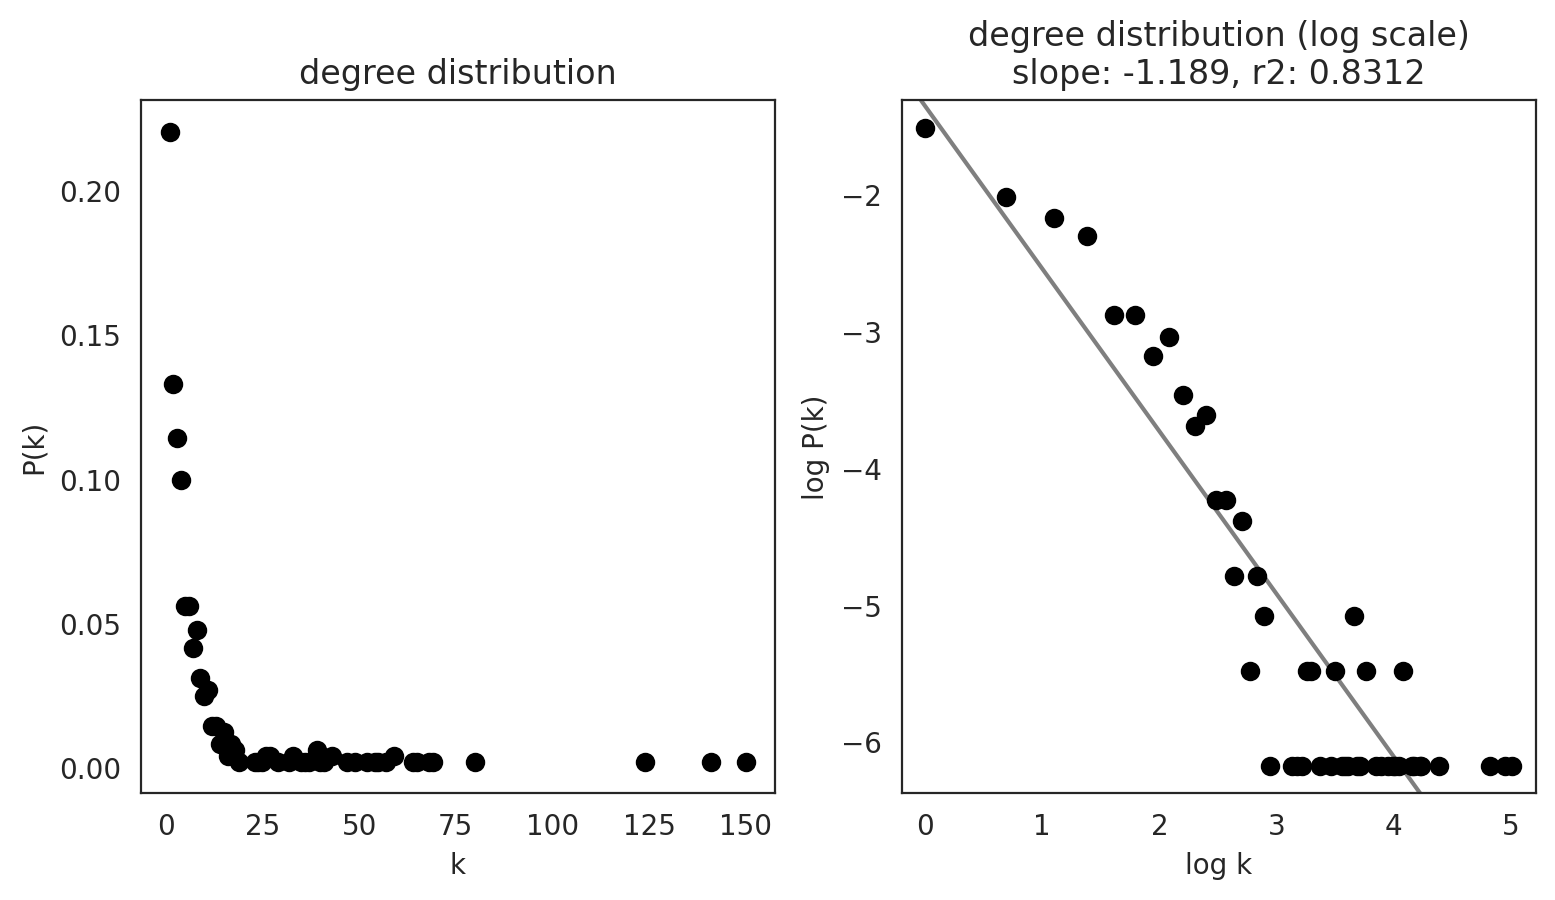

24


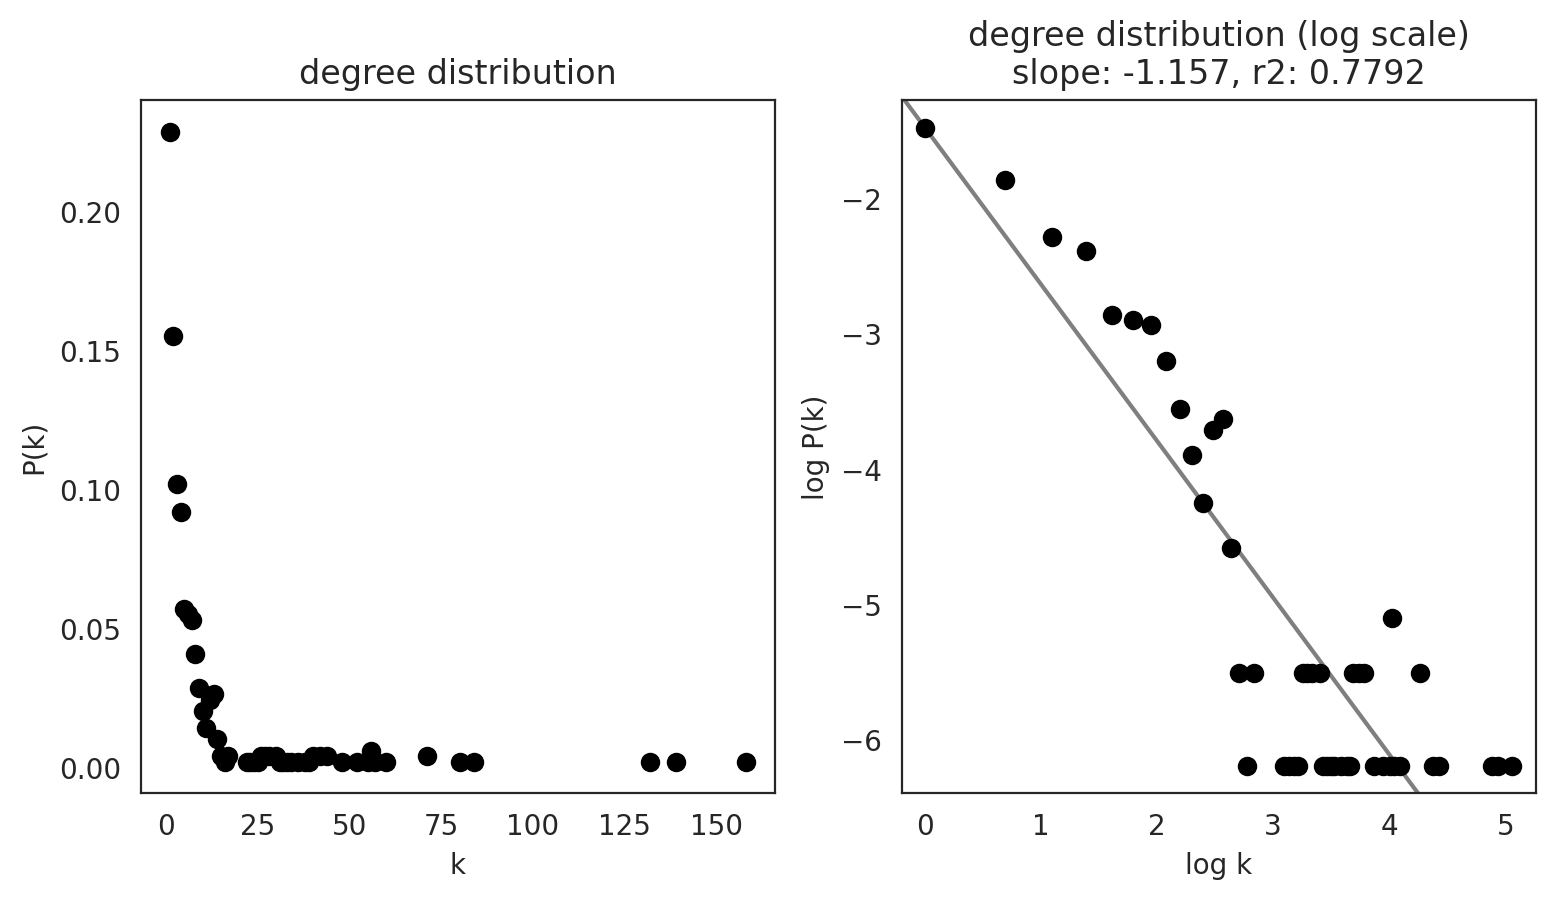

25


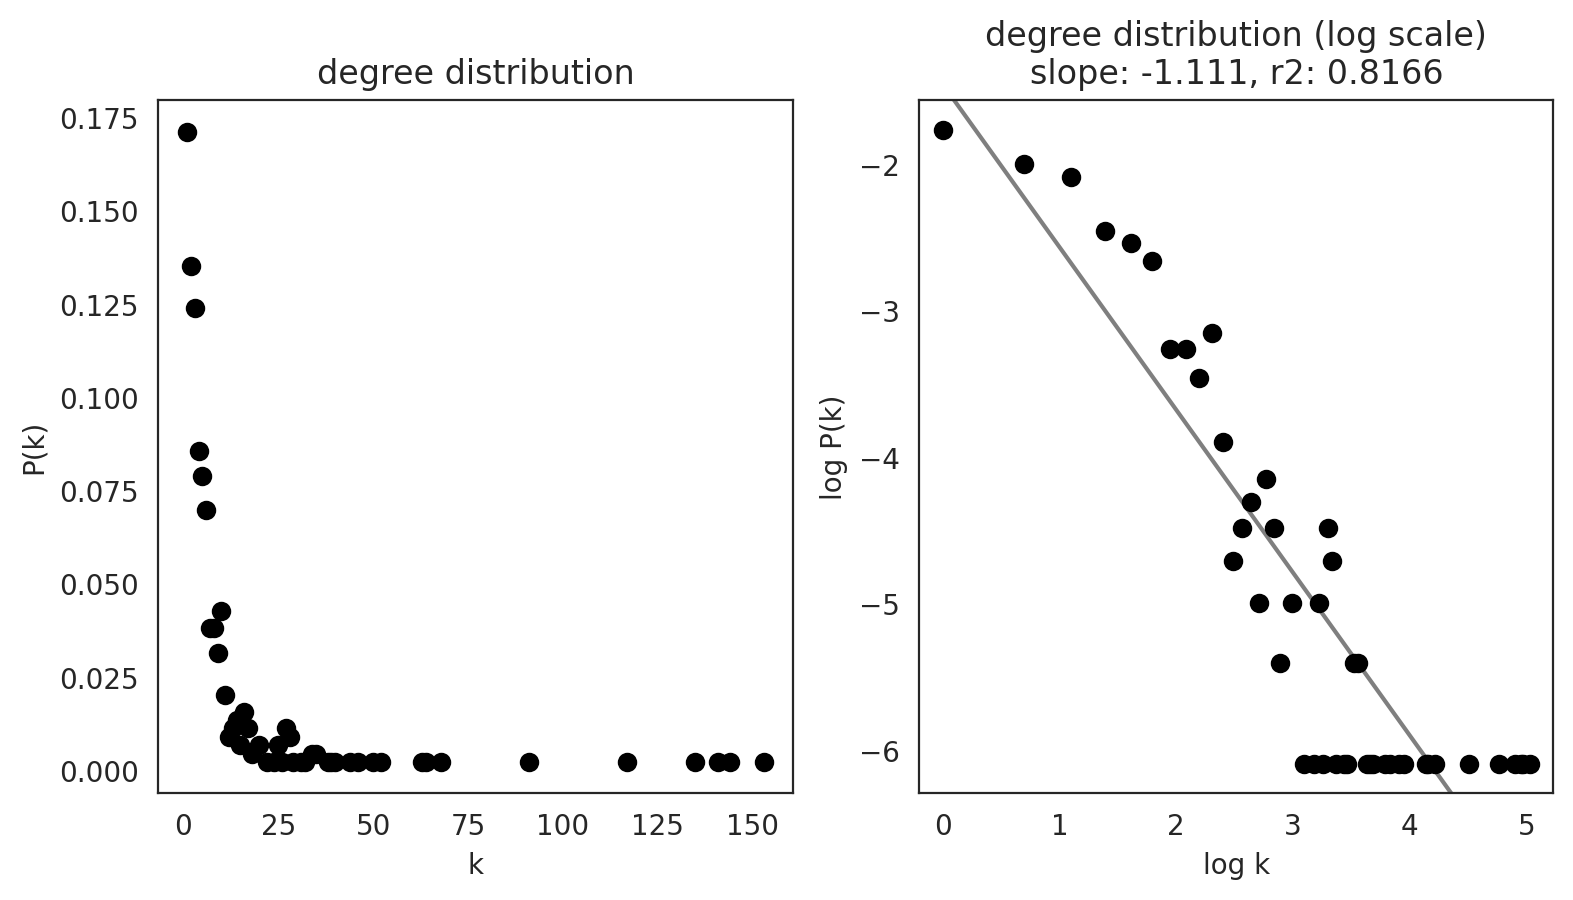

26


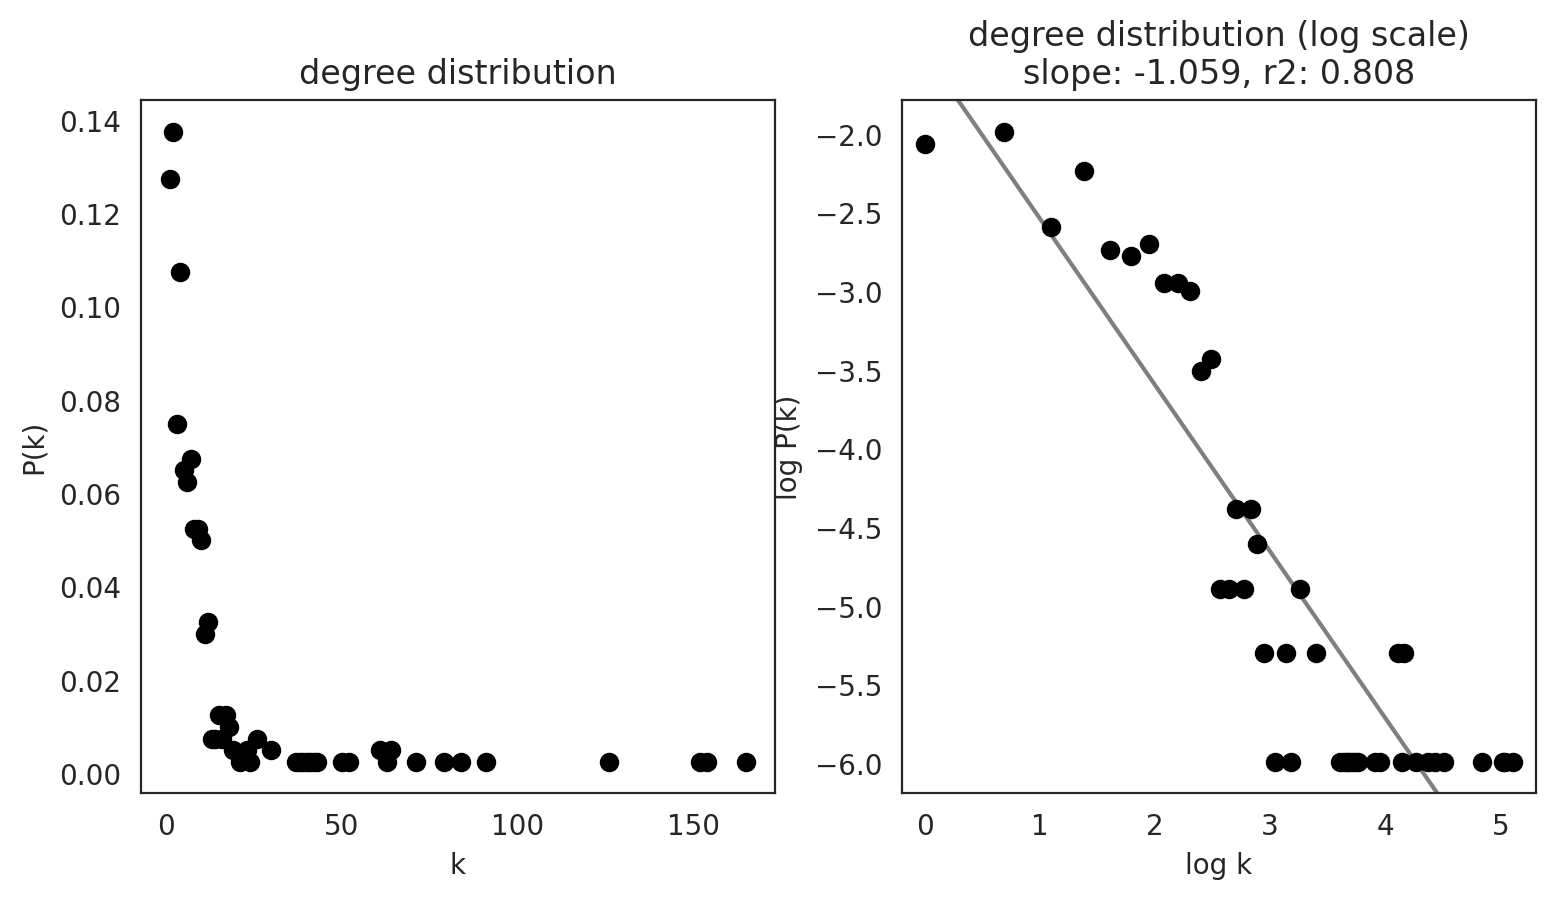

27


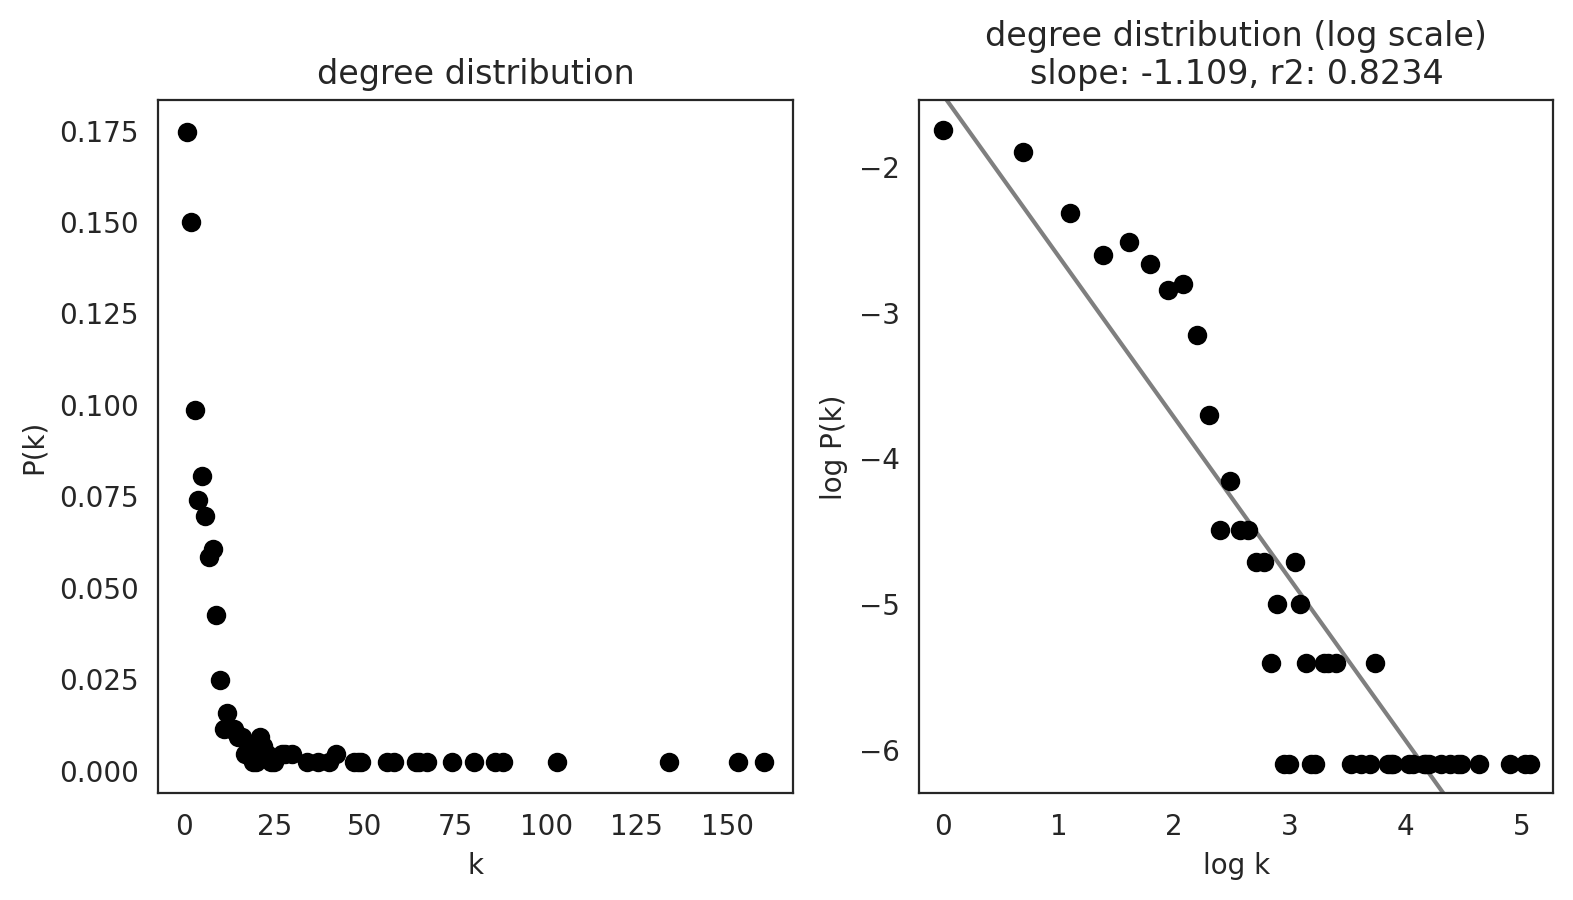

28


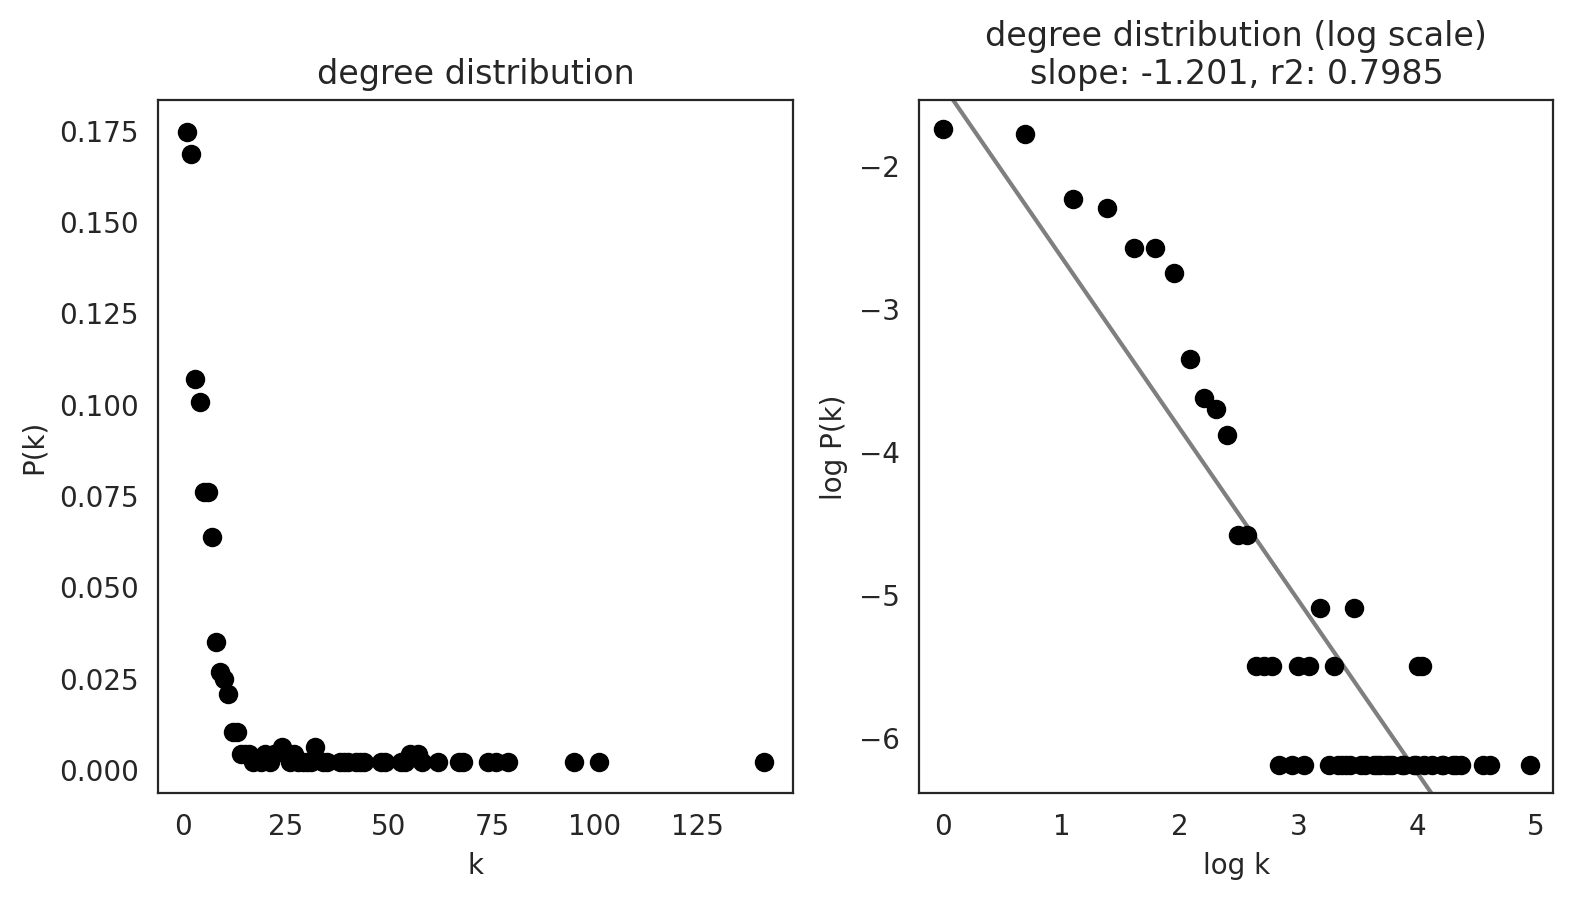

29


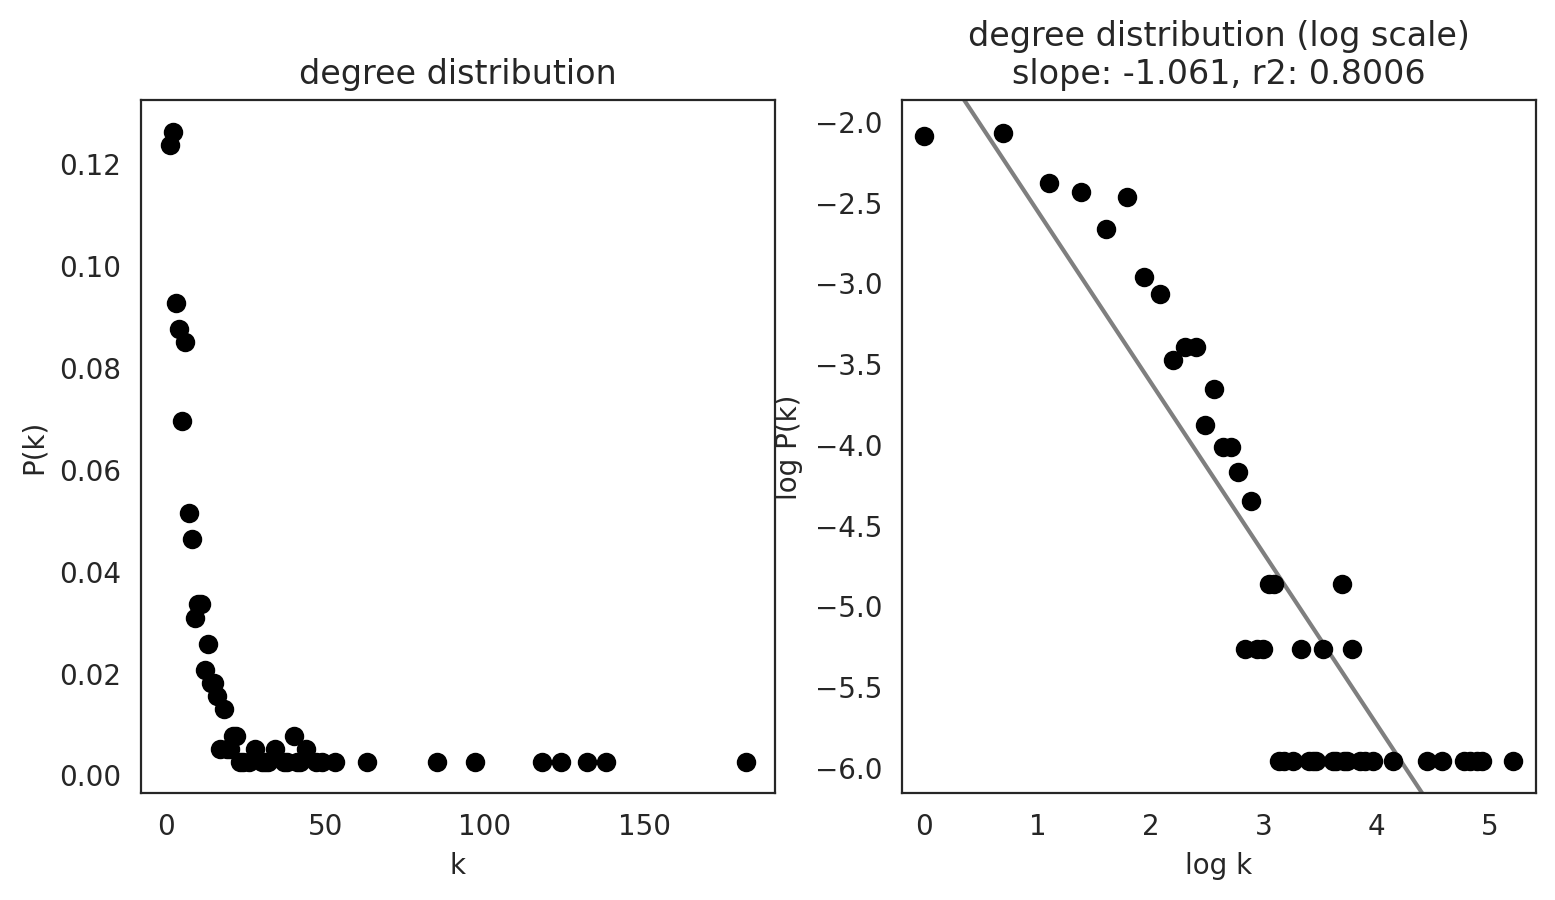

3


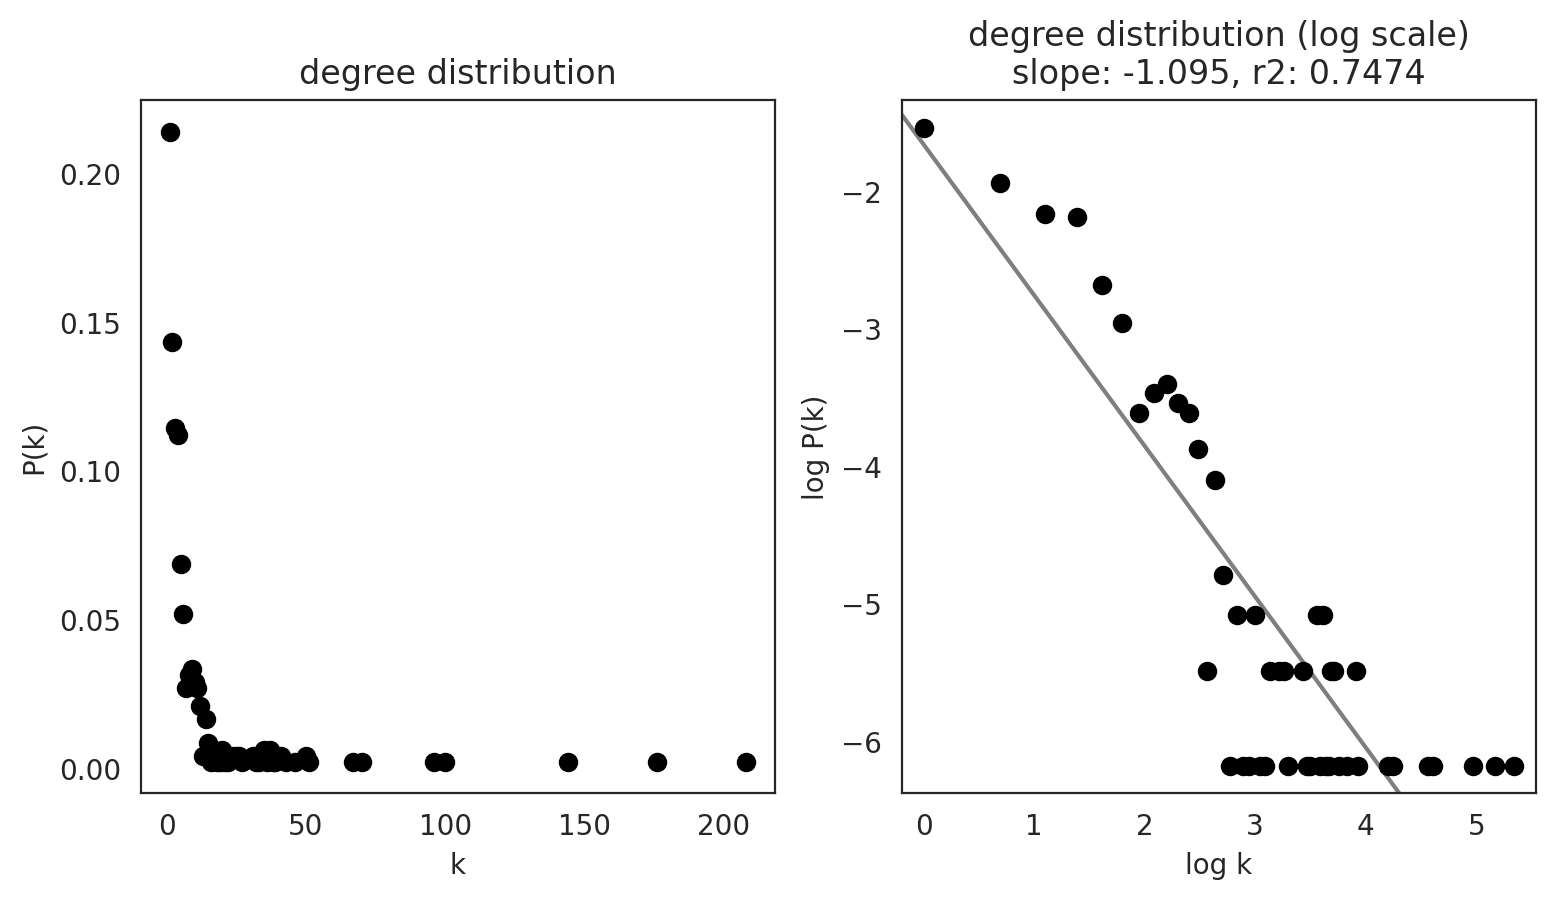

30


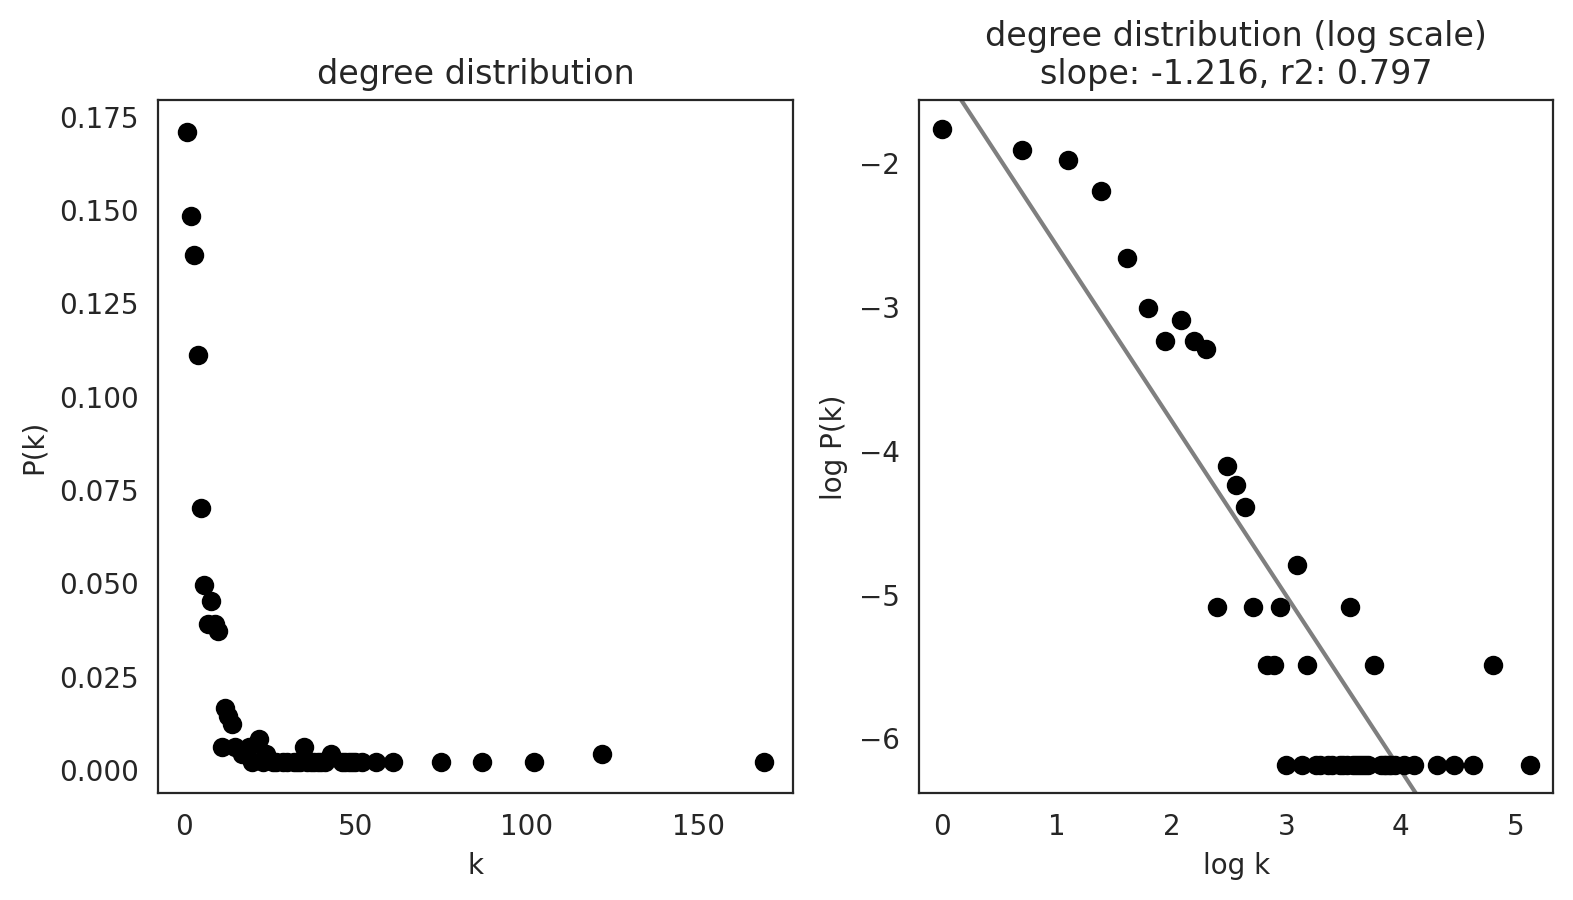

31


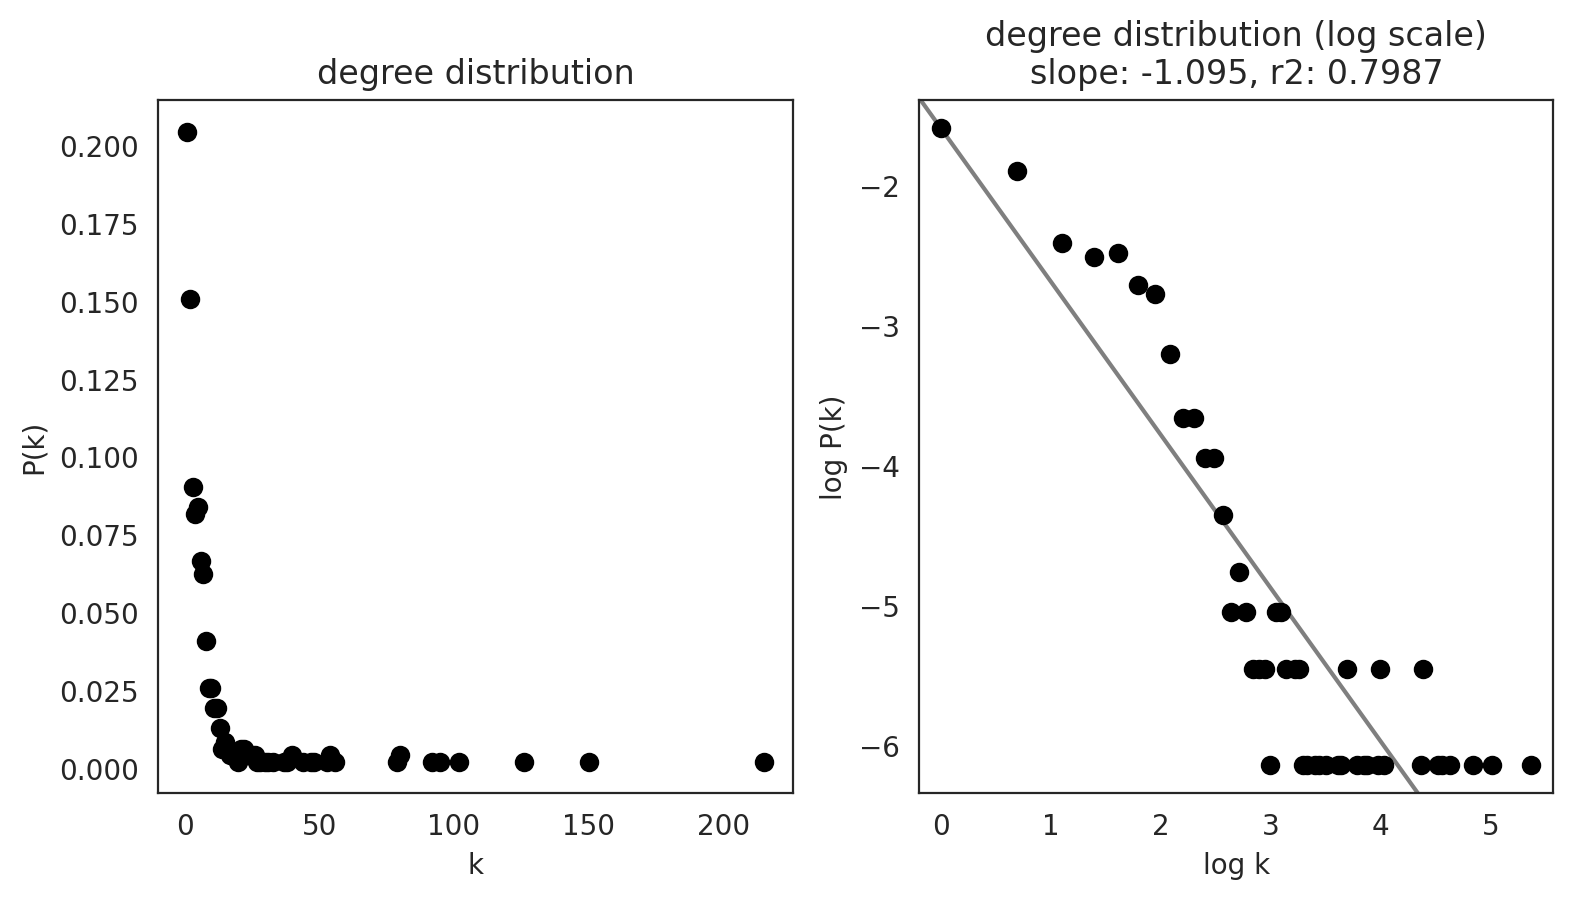

32


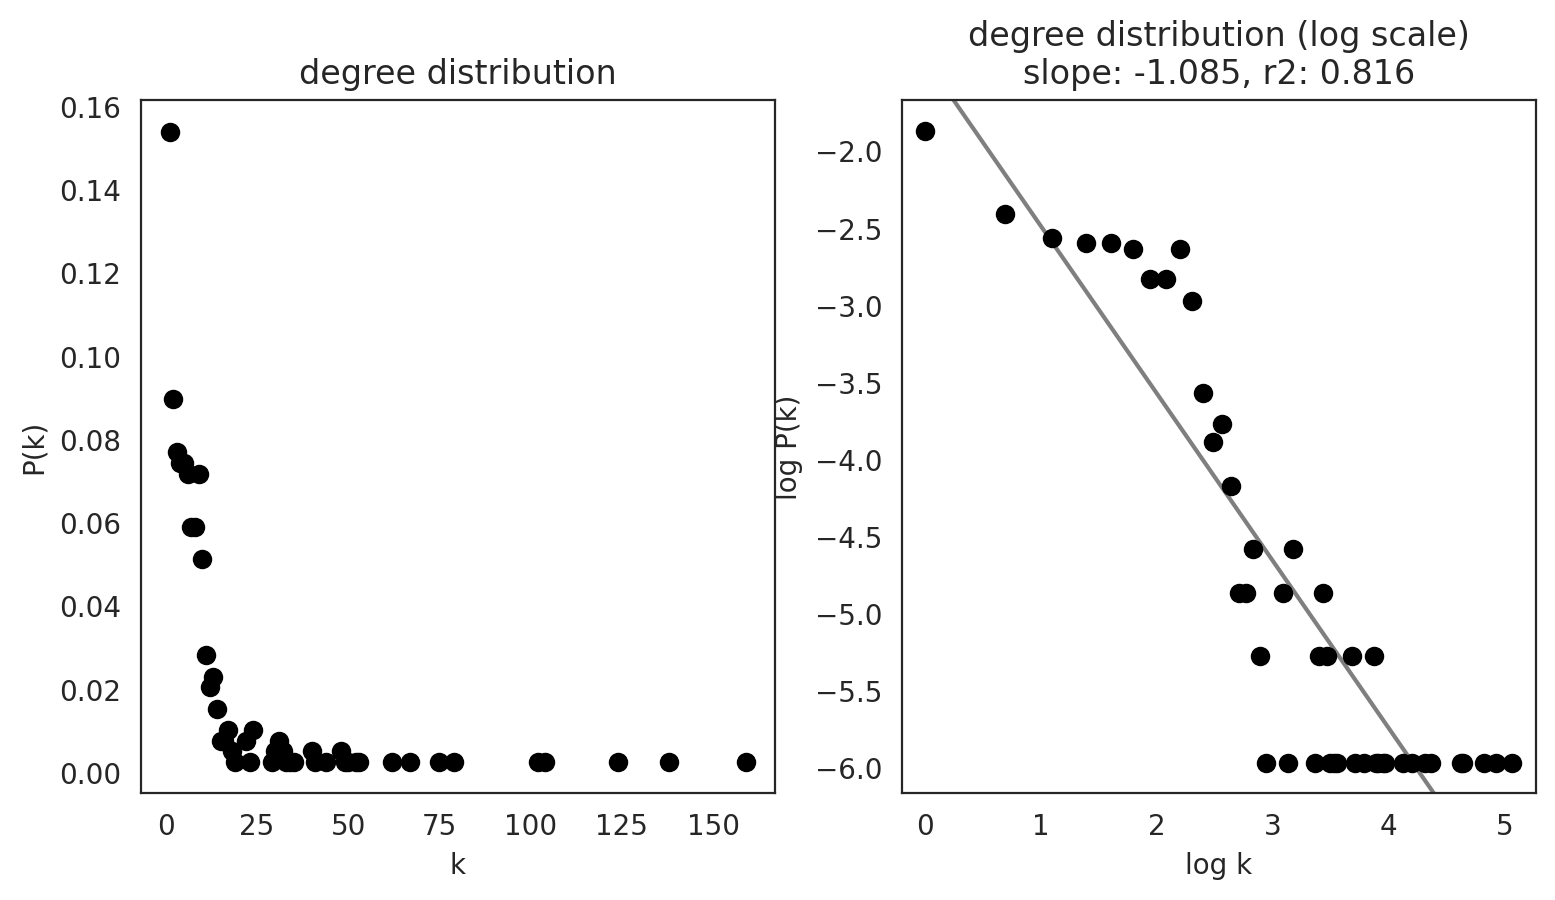

33


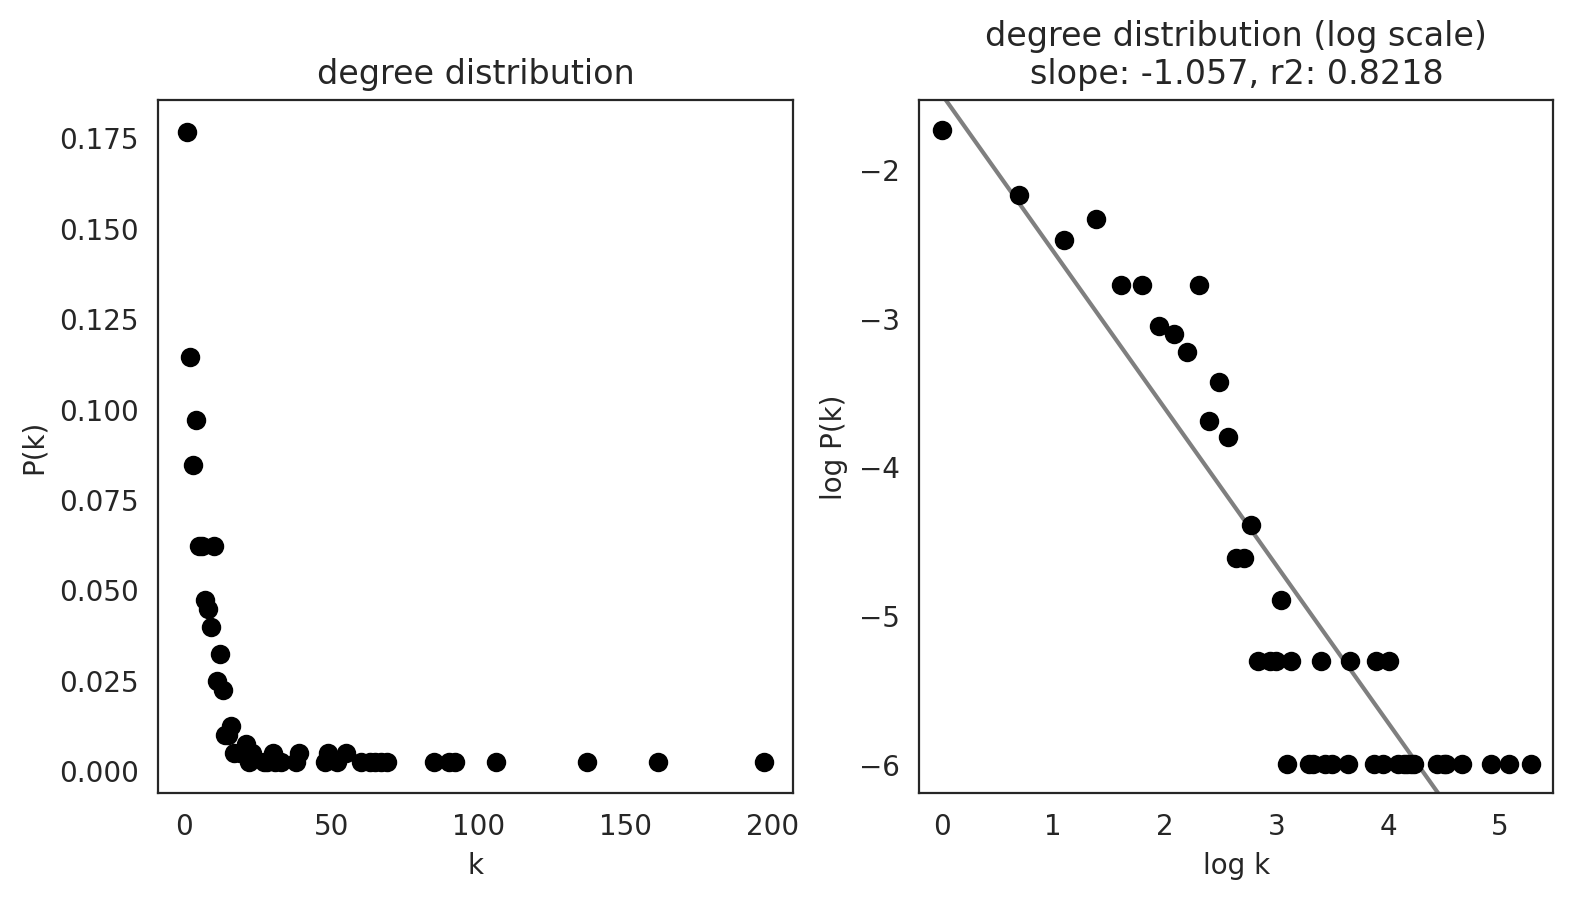

4


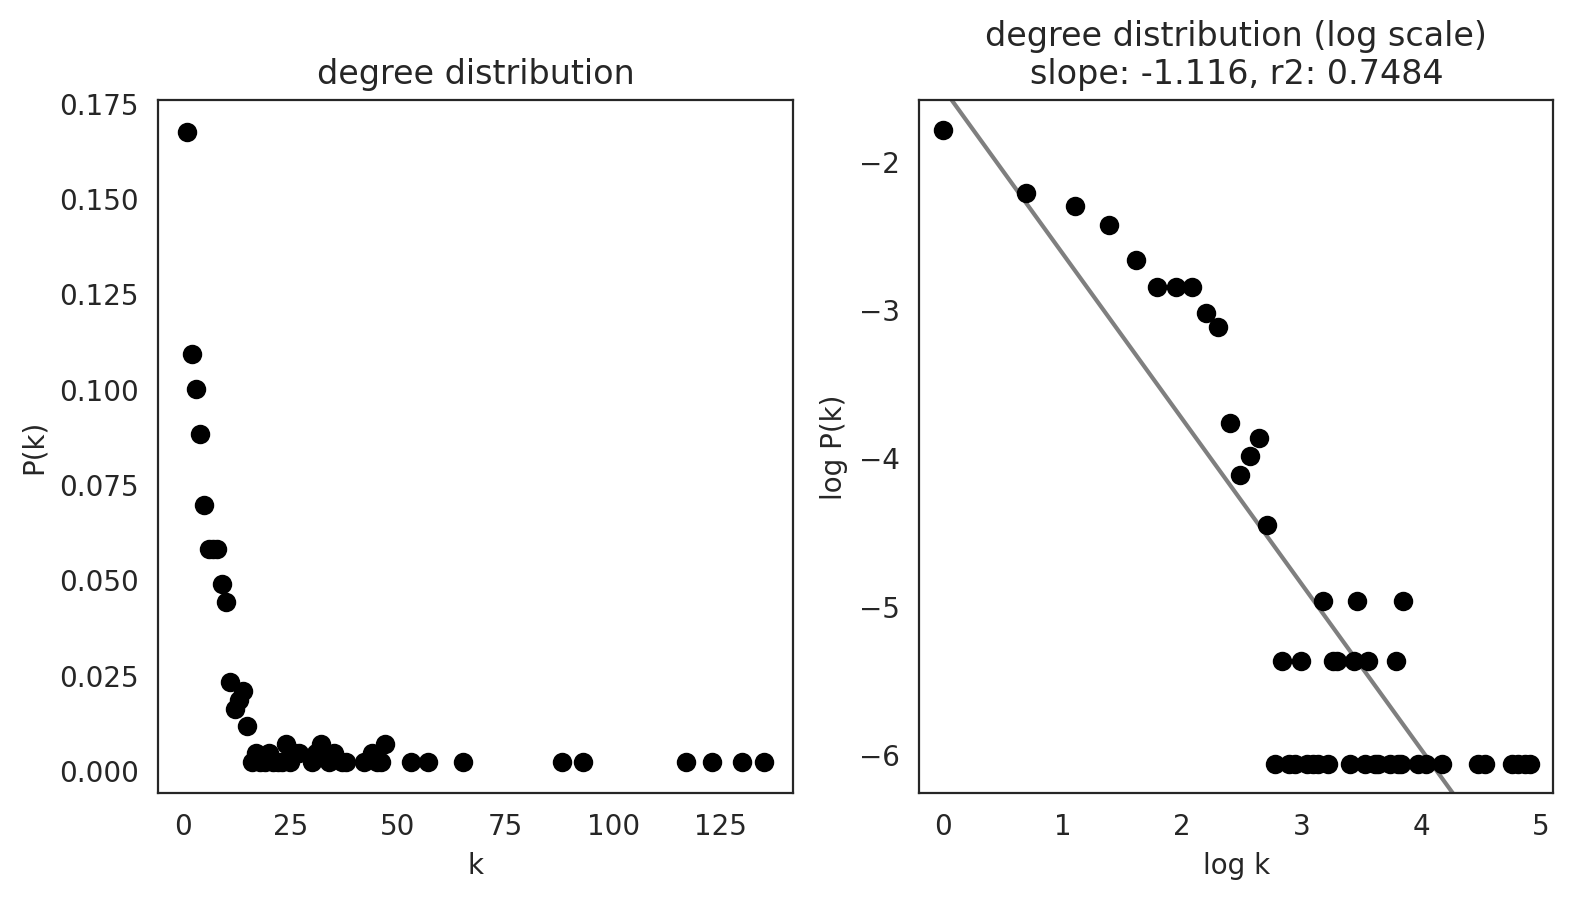

5


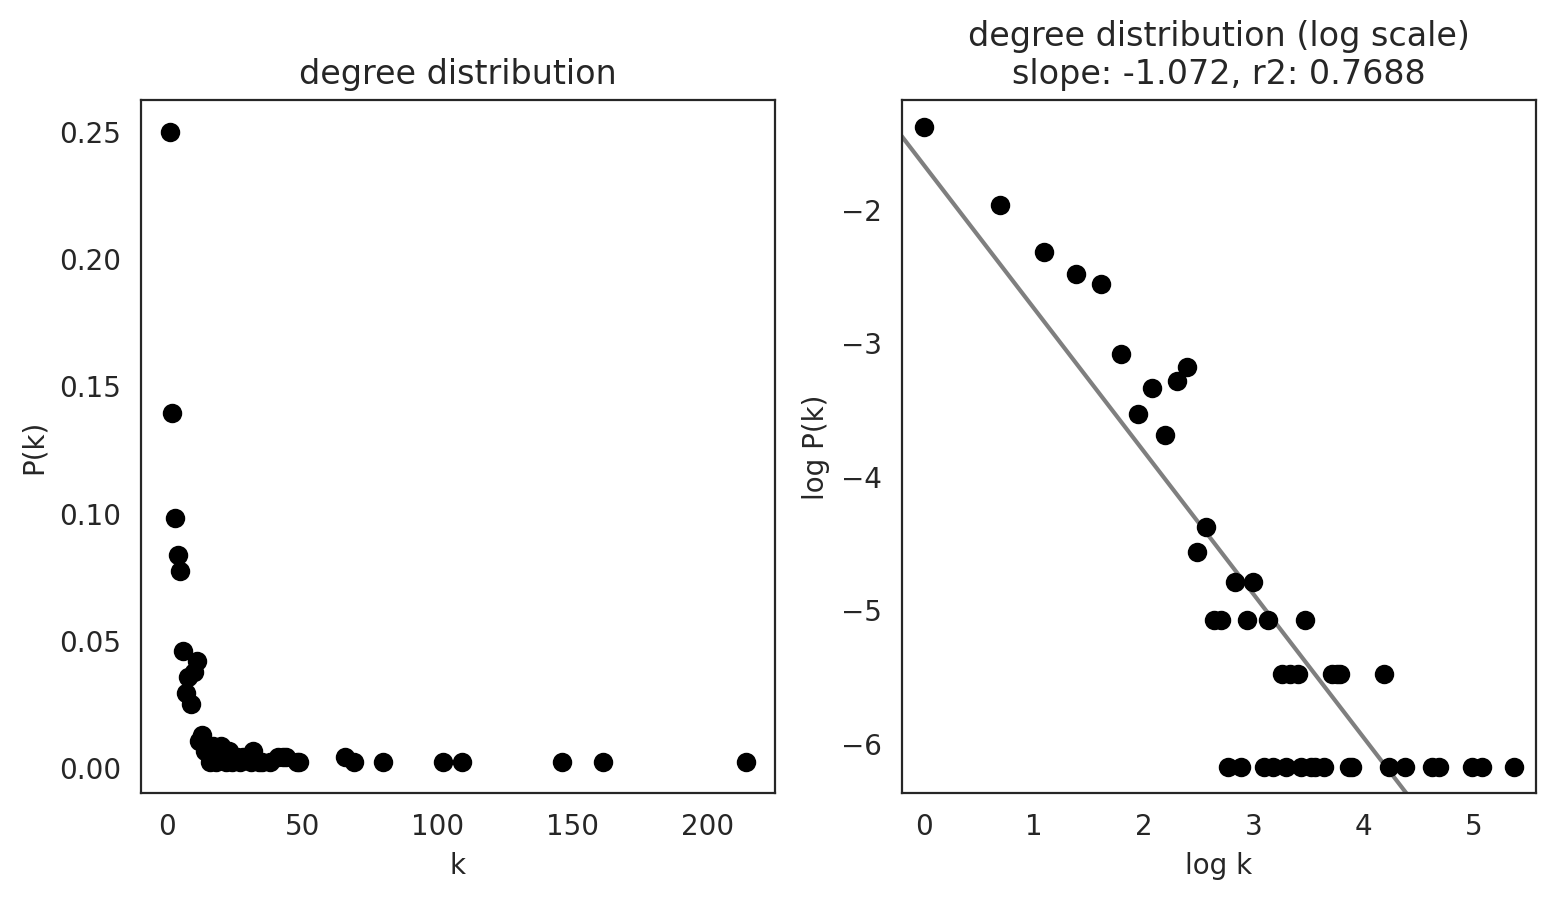

6


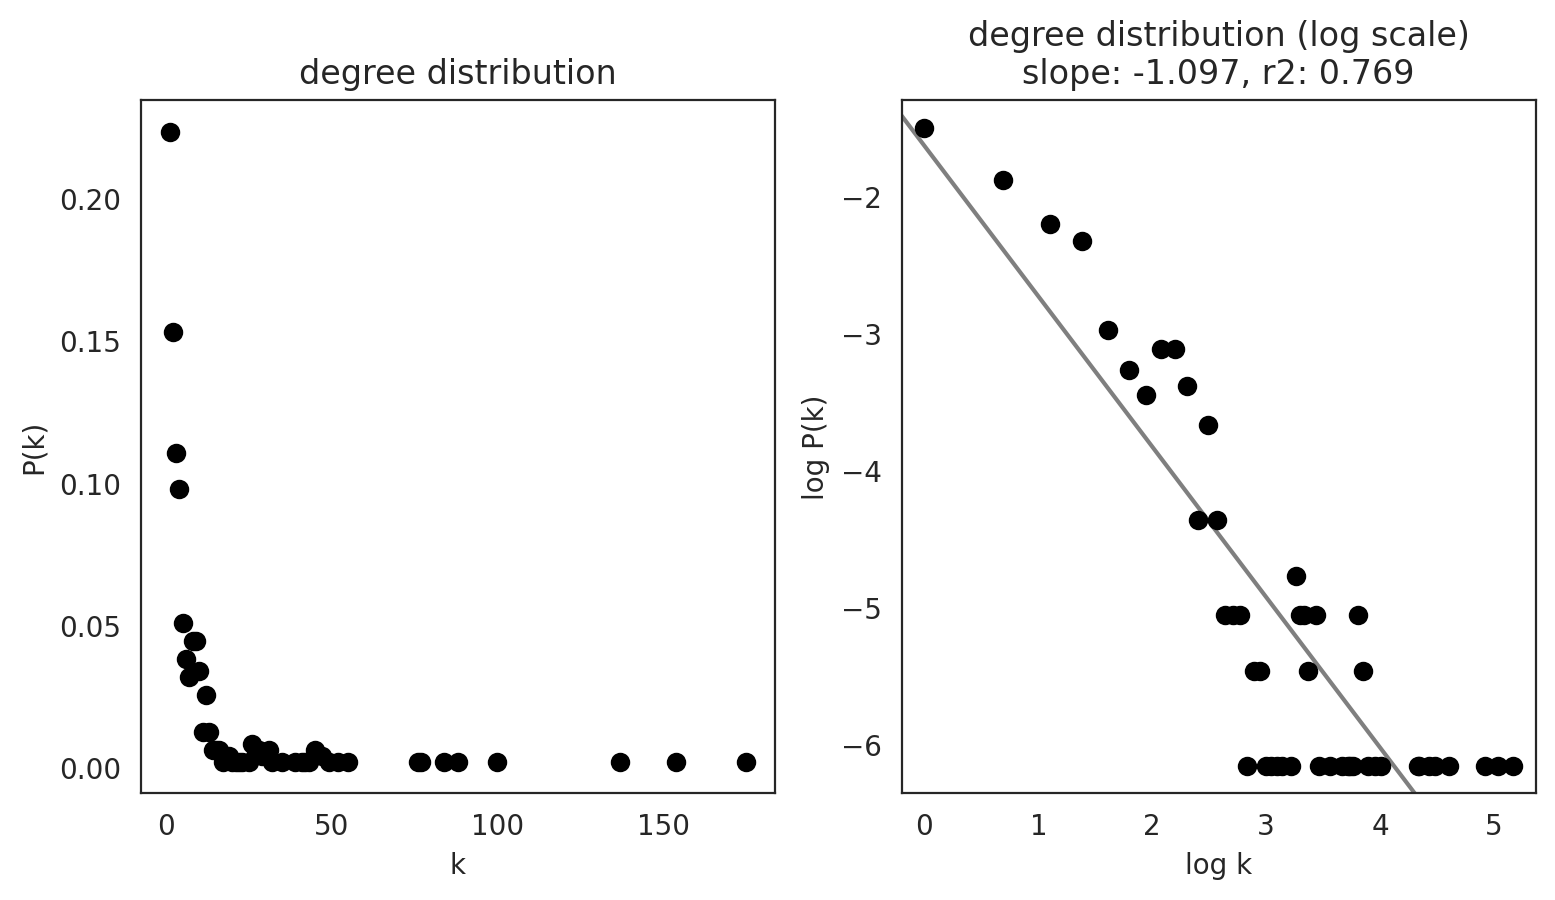

7


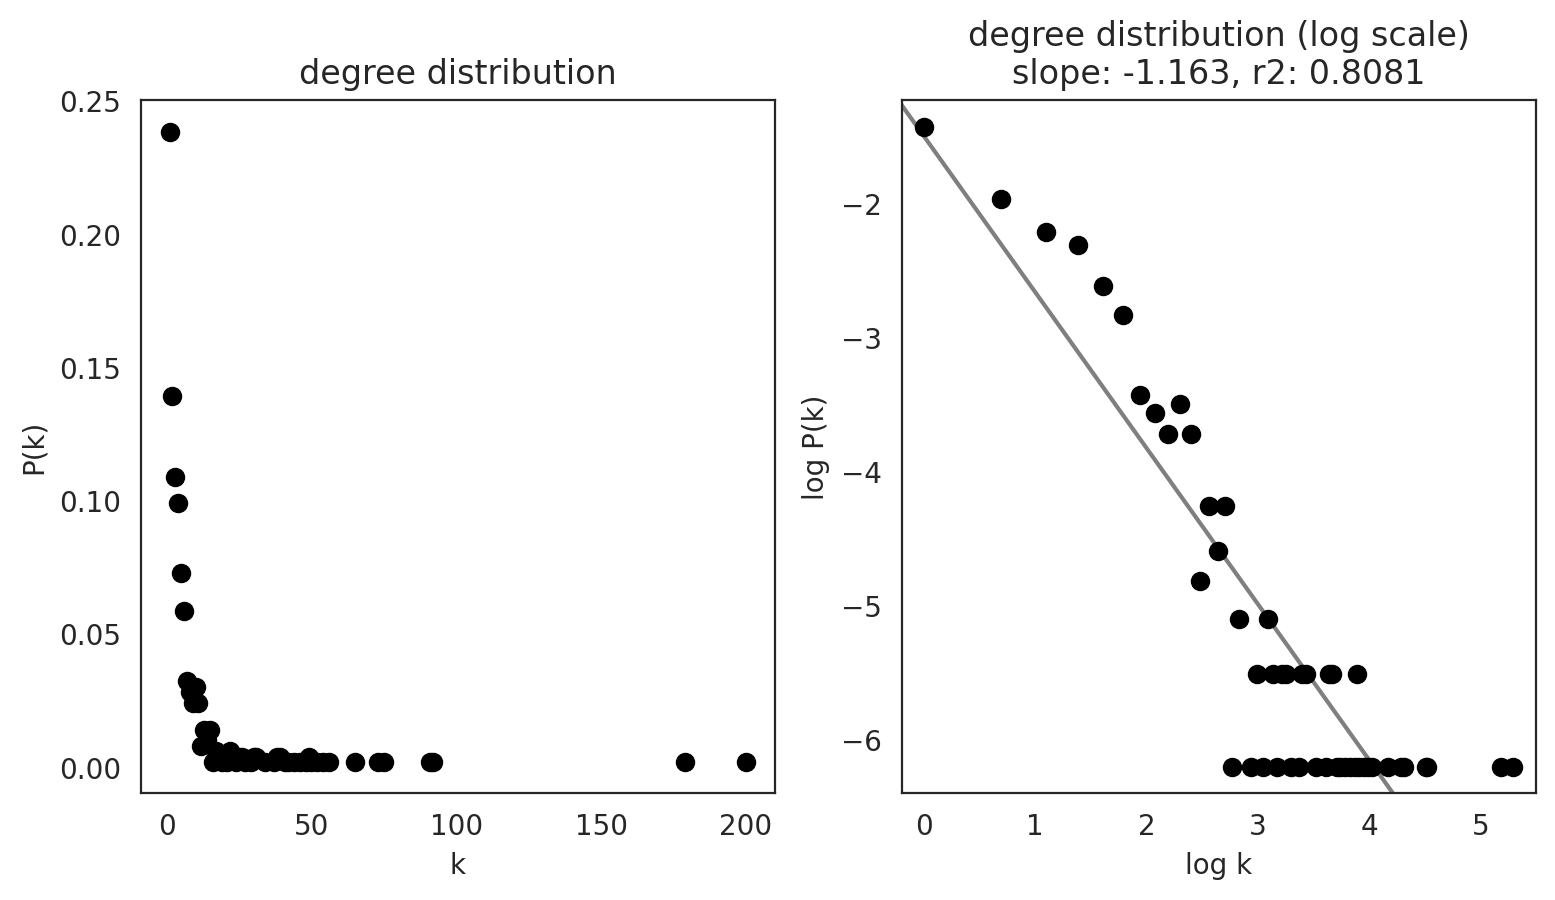

8


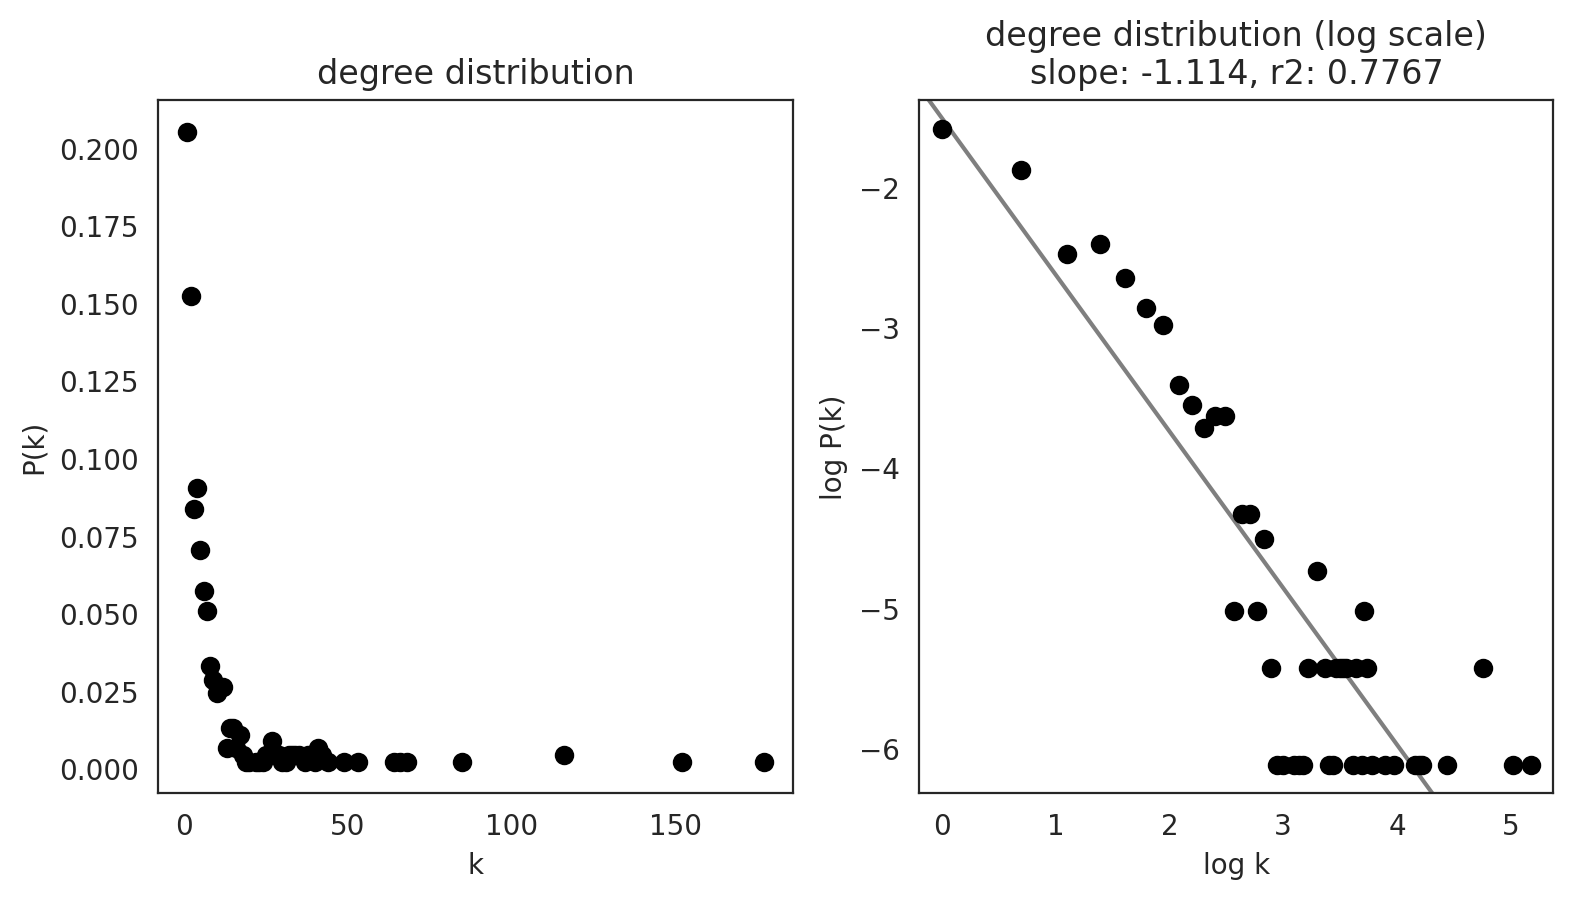

9


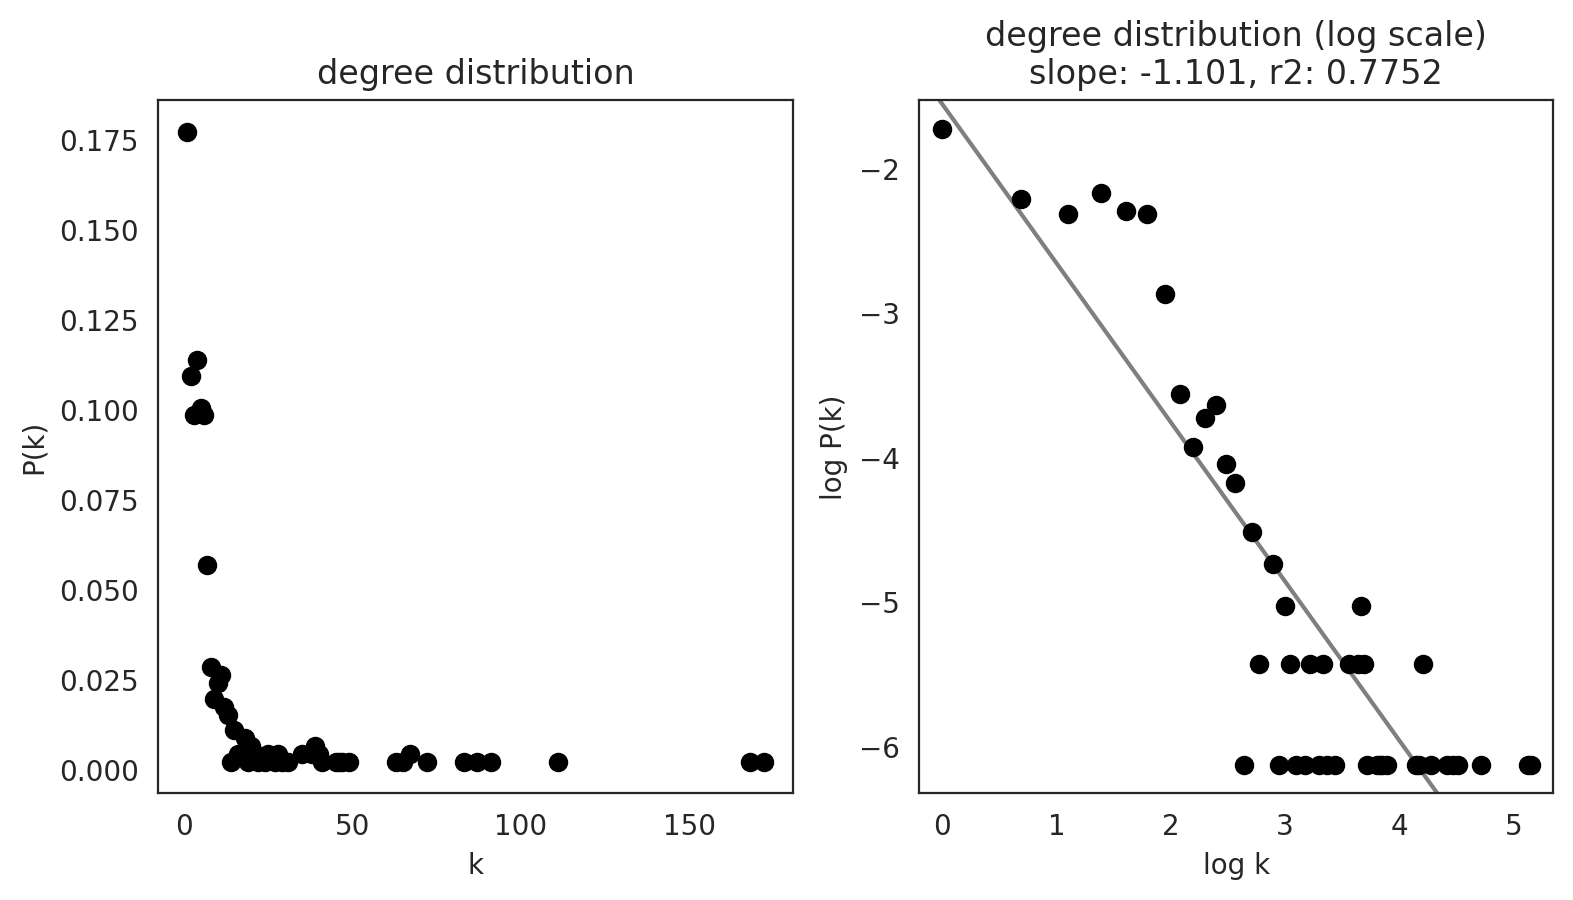

In [32]:
links.plot_degree_distributions(plot_model=True,
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

In [33]:
# Calculate network scores.
links.get_network_score()

In [34]:
links.merged_score.head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
FOS           161               0.329918          1              0.002049   
RPLP1           4               0.008197          4              0.008197   
RPLP2          19               0.038934         19              0.038934   
RPL13          11               0.022541         11              0.022541   
BACH1          60               0.122951          8              0.016393   

       degree_out  degree_centrality_out  betweenness_centrality  \
FOS           160               0.327869                    24.0   
RPLP1           0               0.000000                     0.0   
RPLP2           0               0.000000                     0.0   
RPL13           0               0.000000                     0.0   
BACH1          52               0.106557                  2106.0   

       eigenvector_centrality cluster  
FOS                  1.000000       0  
RPLP1                0.469923       0  
RPLP2                0.537622       0  
RPL13                0.519133       0  
BACH1                0.282937       0

In [35]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

In [36]:
# Check cluster name
links.cluster

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

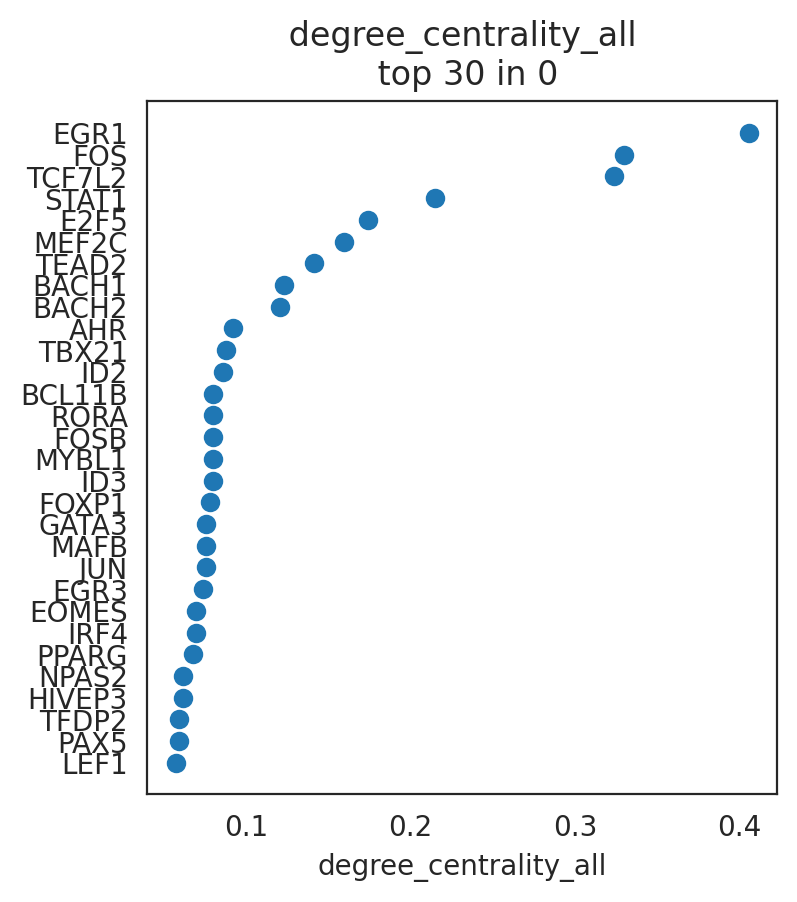

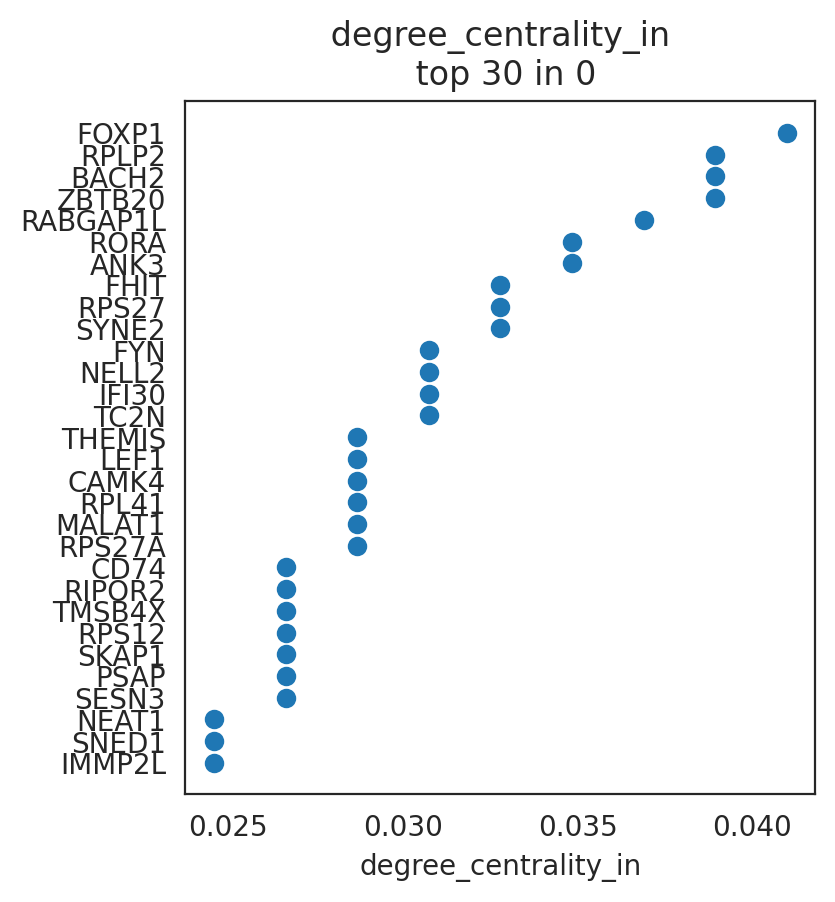

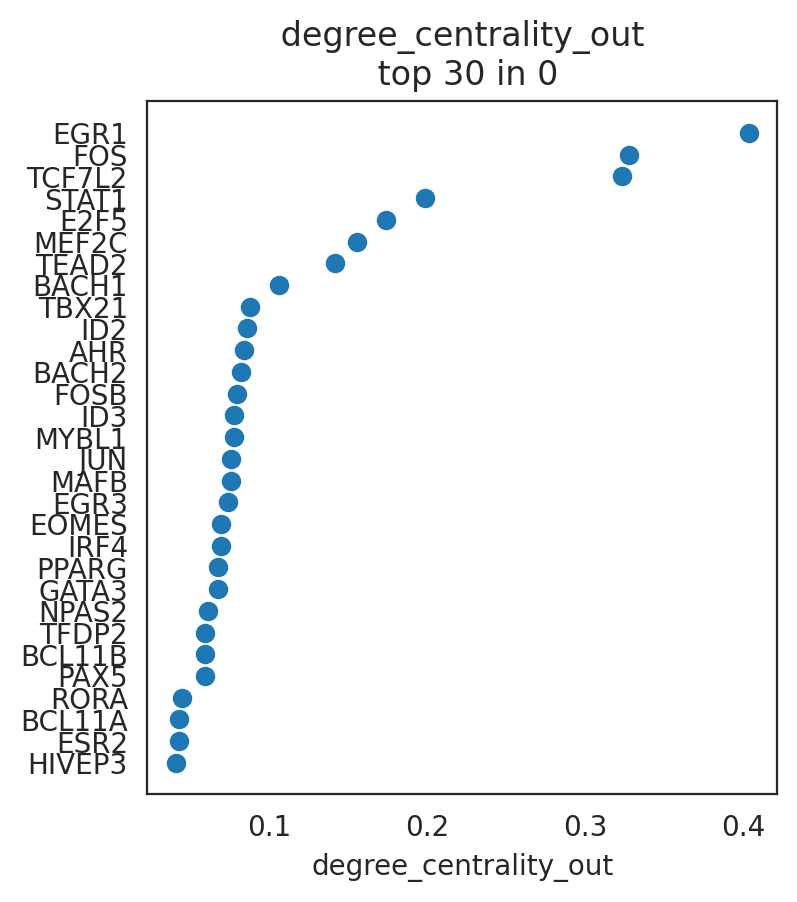

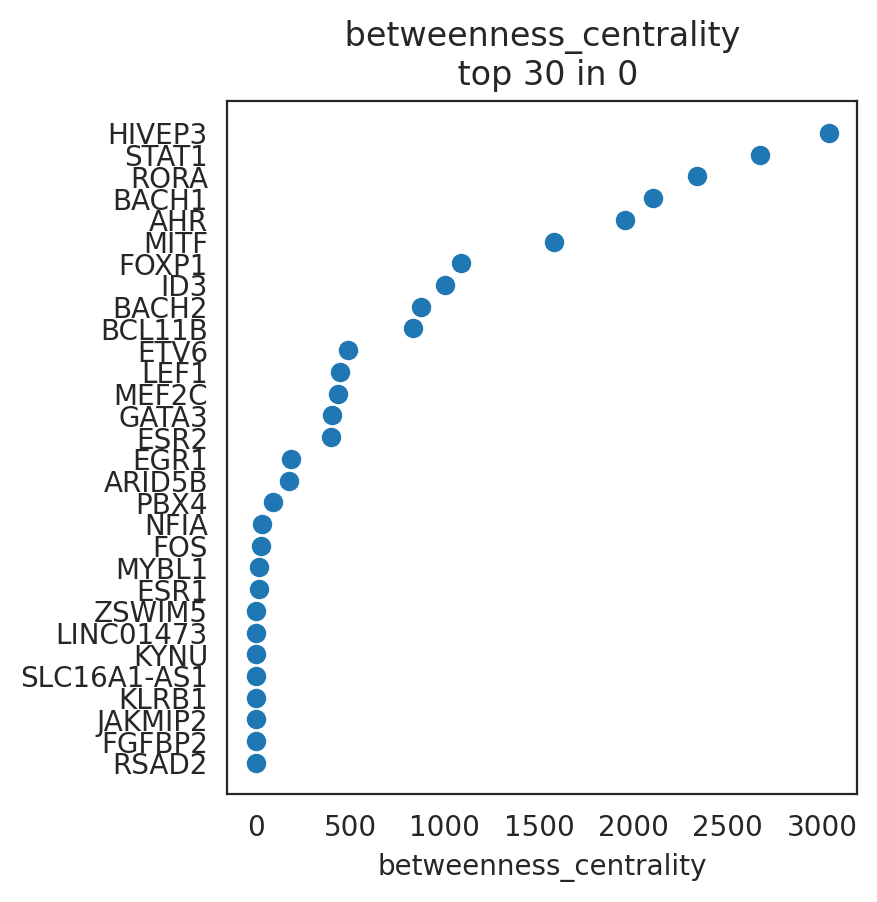

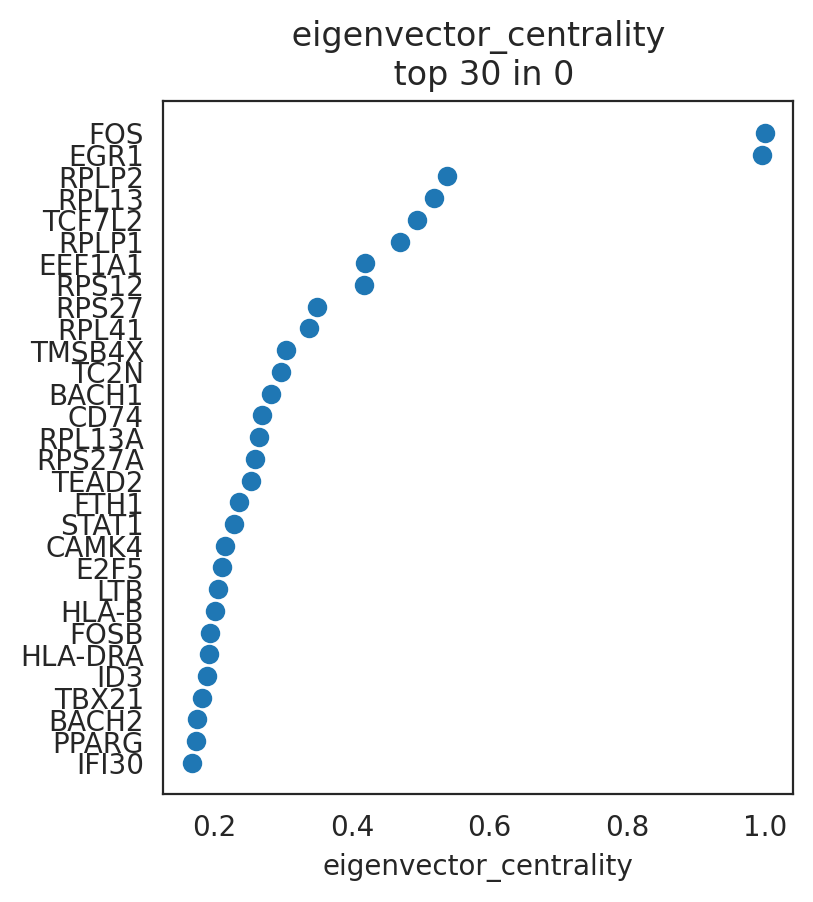

In [38]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="0", n_gene=30, save=f"{save_folder}/ranked_score")

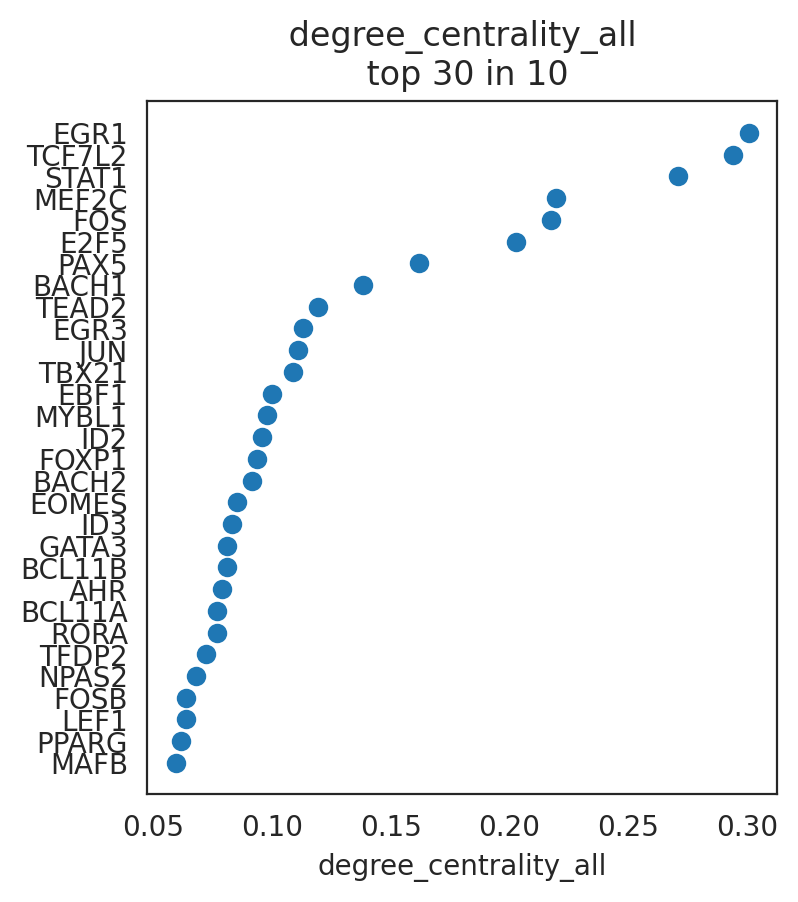

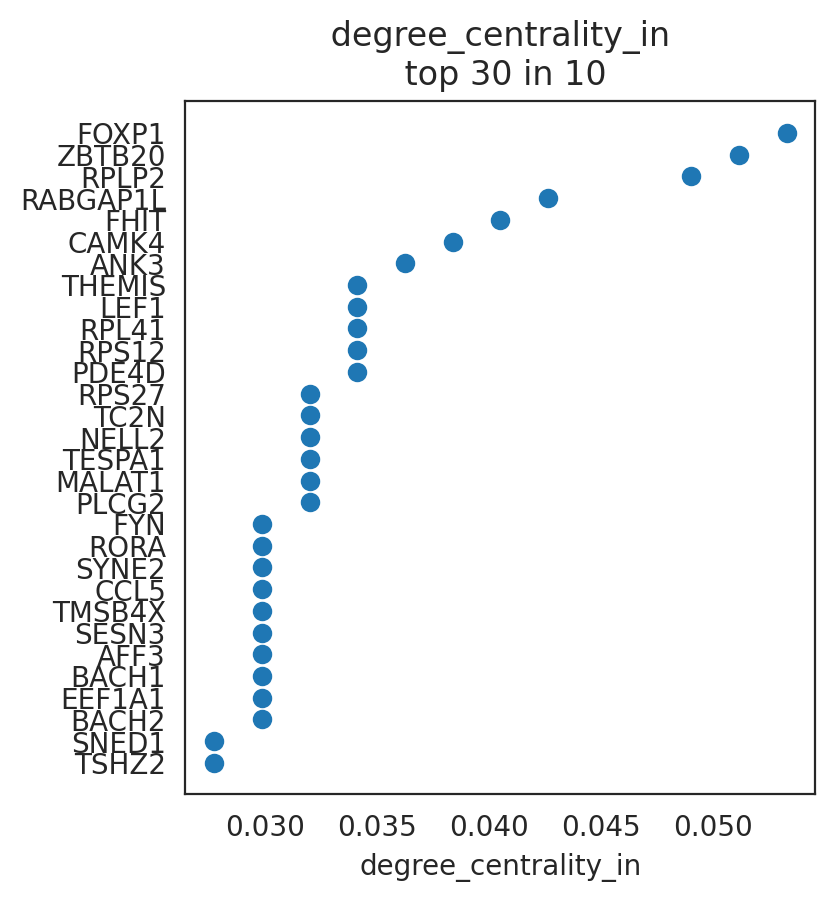

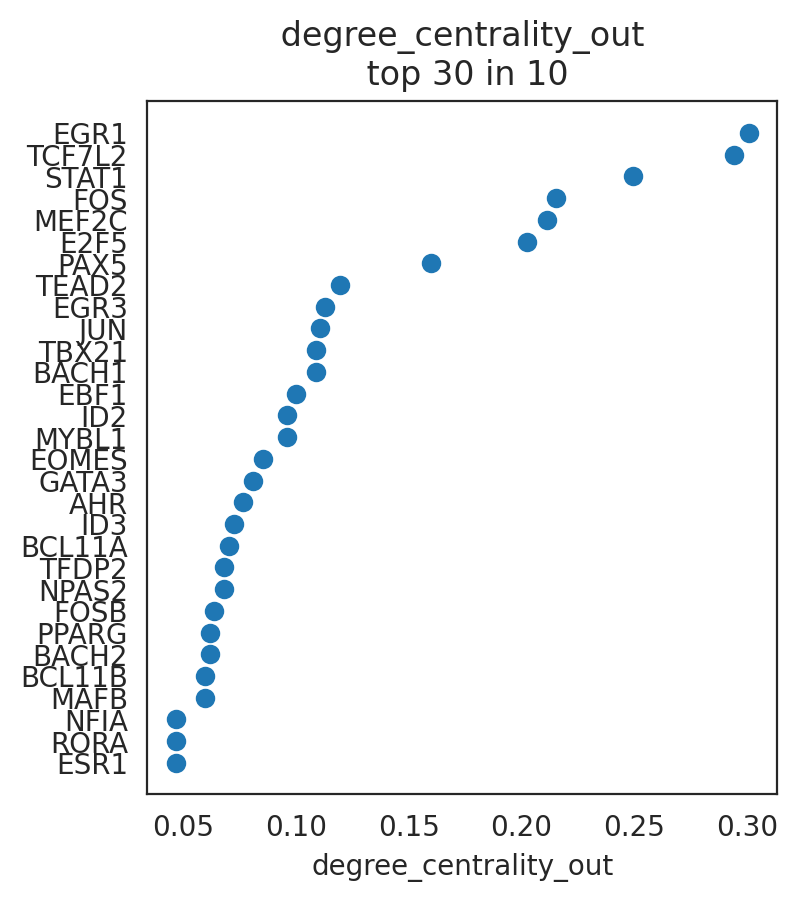

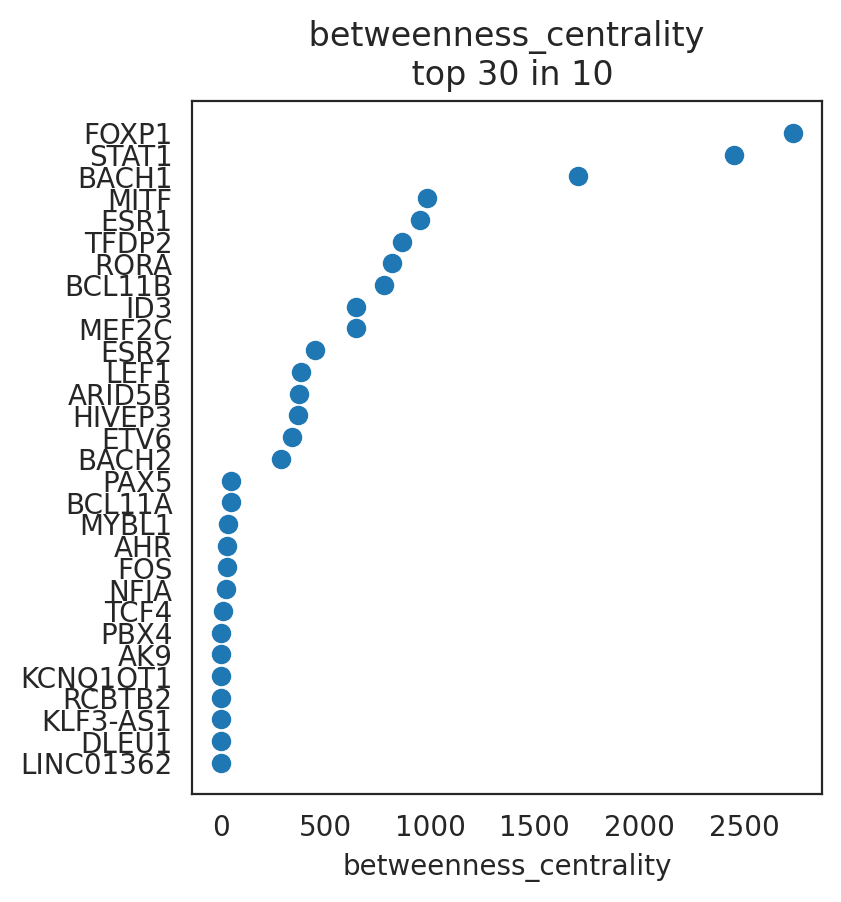

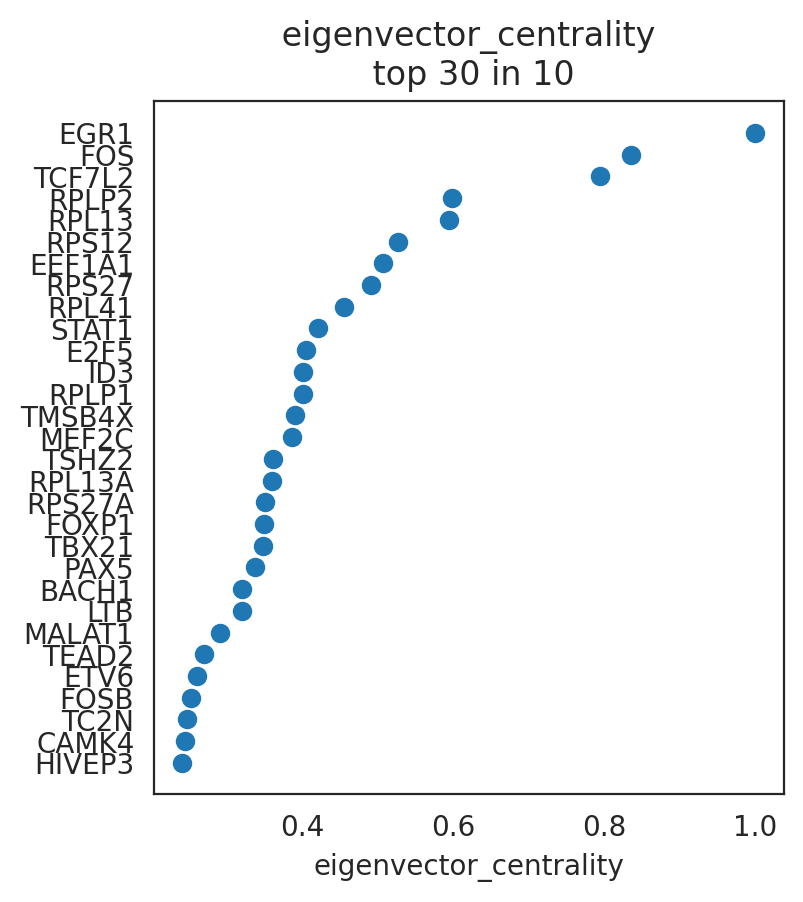

In [45]:
links.plot_scores_as_rank(cluster="10", n_gene=30, save=f"{save_folder}/ranked_score")

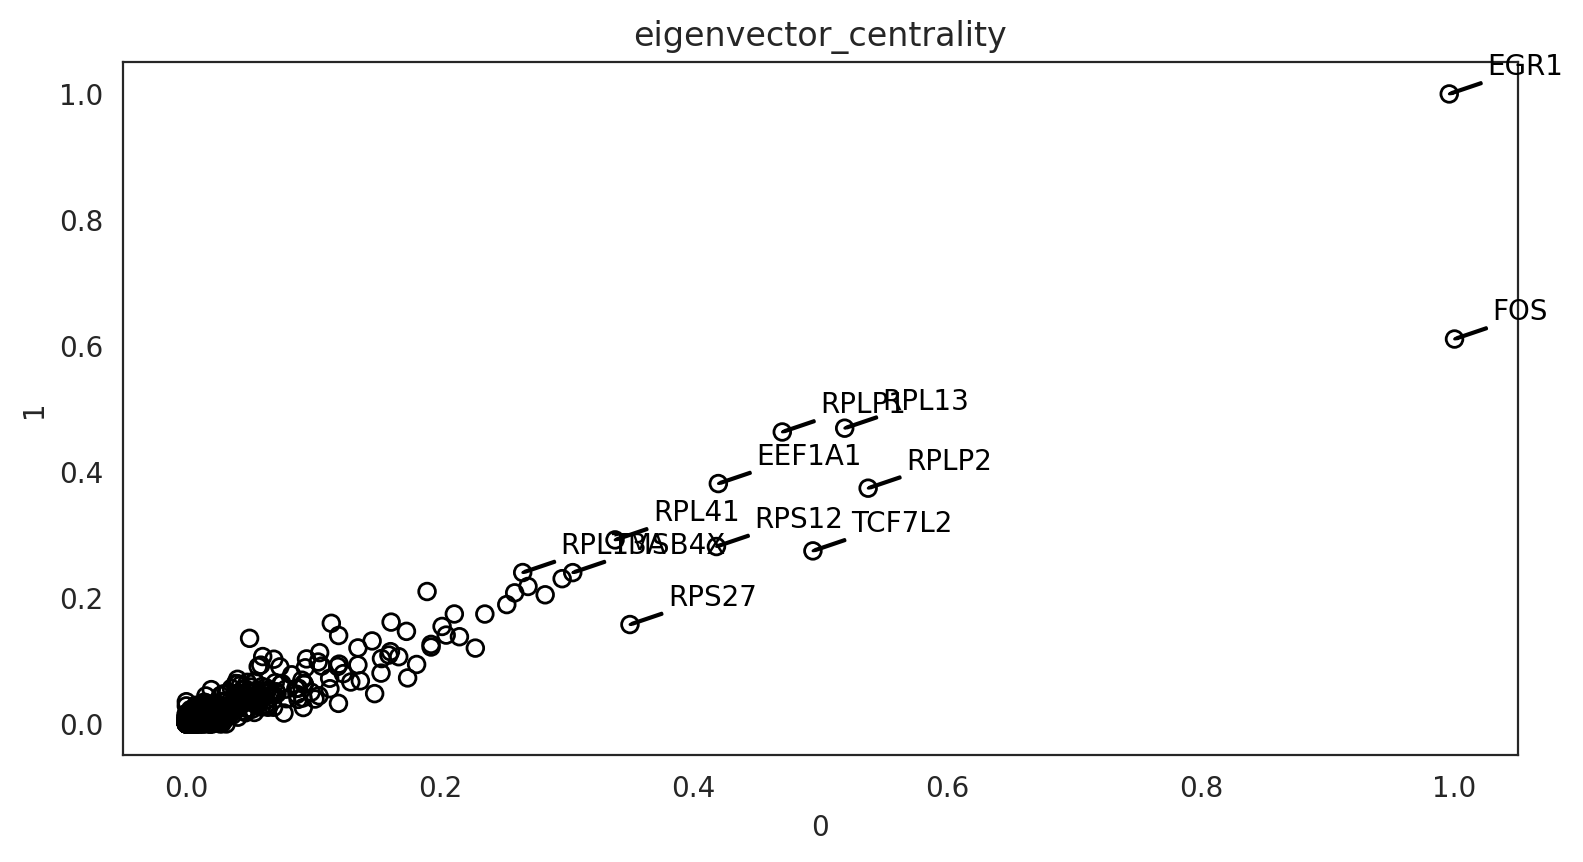

In [40]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="0", cluster2="1",
                               percentile=98,
                               save=f"{save_folder}/score_comparison")

degree_centrality_all


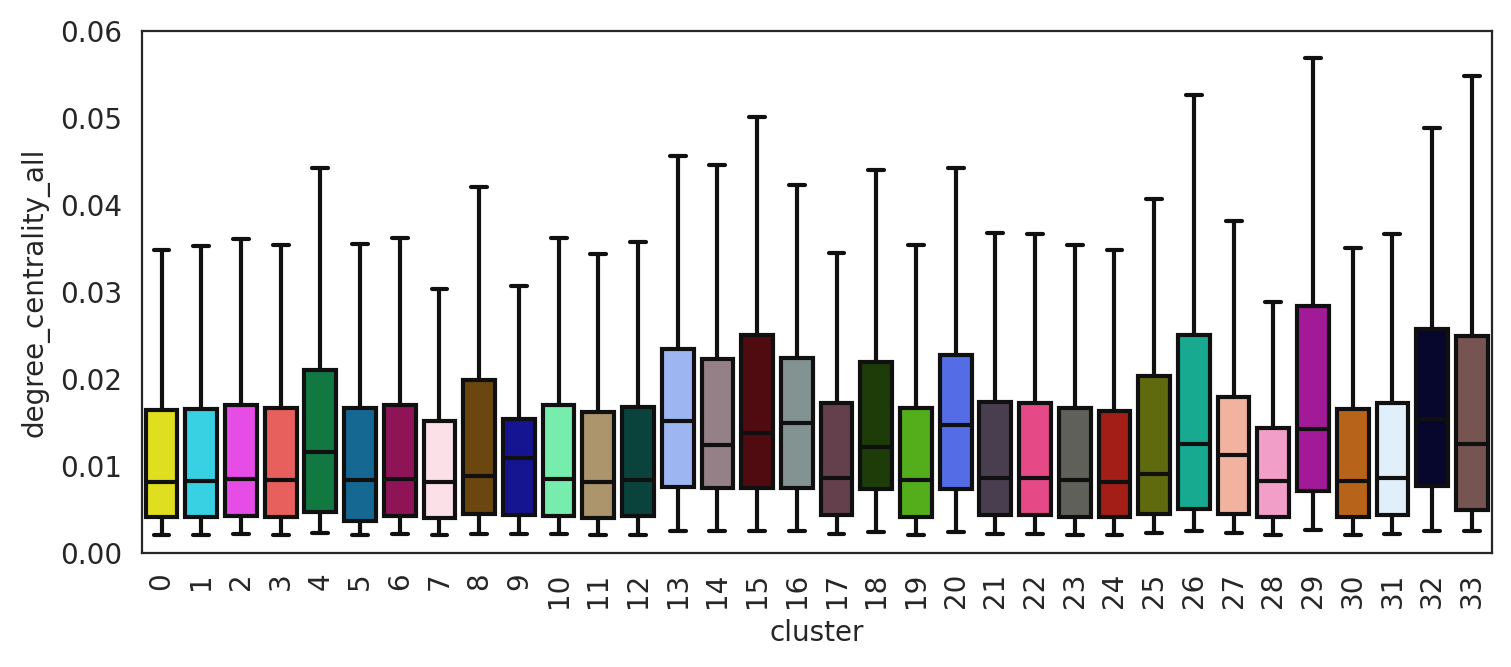

In [44]:
# Plot degree_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.060])
links.plot_score_discributions(values=["degree_centrality_all"],
                               method="boxplot",
                               save=f"{save_folder}",
                              )

